I've been a user of Spotify now since 2017 and during that time I've created a myriad of playlists, most of which I'm willing to admit I haven't touched in a long time. Generally speaking, my playlists fall into one of four categories. 

First, and most predominantly, is based on time. I create bimonthly playlists in which I add songs I've enjoyed throughout the two months, at the end of the year I'll compile all 6 of those into a yearly round-up playlist. Second is based on music genre, I have playlists for each genre I listen to (of course there's bound to be a bit of overlap). Third is based on language, I listen to a mixture of English, Japanese, Korean, and Cantonese songs. Fourth, and finally, are playlists created from song radios or other Spotify-generated means.

One thing that you might not know about Spotify is that it has an API that can be used by developers to create Spotify apps. It's called the [Spotify Web API](https://developer.spotify.com/documentation/web-api/reference/) and it allows you to control audio playback, manage your Spotify library, get metadata of tracks, artists, and albums, and so much more. I'm utilising the `Spotipy` Python library to use it. For my purposes I'll be using it to get my playlists' metadata and the audio features of tracks.

In this blog we'll be going on a journey that explores my playlists in a data-driven way and eventually produce a machine learning algorithm that gives the most similar tracks in my playlists when provided with a track.

In [1]:
#| echo: false

# Used to enable plotly to work in VS Code
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [2]:
#| echo: false

import umap
import phik
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from os import path
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import jaccard_score
from ast import literal_eval

sns.set_theme(style='whitegrid')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [4]:
#| echo: false

# Helper objects

# Save filepaths
FIG_SAVE_PATH = r"C:\Users\Brandon\git\spotify-recommender-system\reports\figures"
DATA_RAW_PATH = r'C:\Users\Brandon\git\spotify-recommender-system\data\raw'
DATA_PROC_PATH = r'C:\Users\Brandon\git\spotify-recommender-system\data\processed'
PROCESSED_DATA_FP = f'{DATA_PROC_PATH}\spotify_playlist_track_features.csv'

# Mapping for last day of each month
MONTH_LAST_DATE_DICT = {
    1: 31,
    2: 28, # Beware of leap years
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

# Mapping of month to name
MONTH_NAME_DICT = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

# Set columns to perform analysis on
feature_cols = [
    'danceability',
    'energy',
    # 'key',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    # 'time_signature'
]

In [5]:
#| echo: false

# Load in data from previous notebook
df = pd.read_csv(PROCESSED_DATA_FP)

# Convert date col to Timestamp dtype
df['playlist_date_added'] = pd.to_datetime(df['playlist_date_added'], utc=True)

# Add language as indicator columns
# Note that this isn't accurate but works for ~80-85% of tracks? 
for lang in ['Japanese', 'Korean', 'Cantonese']:
    lang_mask = df['playlist_name'] == lang
    lang_artist_ids = df[lang_mask]['artist_id'].unique()
    df.loc[(df['artist_id'].isin(lang_artist_ids)), f"lang_{lang[:3].lower()}"] = 1
    
df = df.fillna(0)
df['lang_eng'] = df.apply(lambda x: 1 if sum([x[f'lang_{lang}'] for lang in ['kor', 'jap', 'can']]) == 0 else 0, axis=1)
df[['lang_kor', 'lang_jap', 'lang_can']] = df[['lang_kor', 'lang_jap', 'lang_can']].astype(int)

# Add genre as indicator columns
# Note that this only captures ~75% of songs, i.e. 75% of songs will have at least 1 of the below genres
genres = ['pop', 'rock', 'hip_hop', 'indie', 'rap', 'alternative']

# Convert genre values from string to list and explode out list into multiple rows
df['genres'] = df['genres'].apply(lambda x: literal_eval(str(x)))
artist_genre_df = df[['artist', 'name', 'genres']].explode('genres')

# Add indicator if genre is in string
for genre in genres:
    artist_genre_df[genre] = artist_genre_df['genres'].apply(lambda x: 1 if ' '.join(genre.split('_')) in str(x) else 0)

# Aggregate by artist and song name their genres
artist_genre_agg_df = (
    artist_genre_df
    .groupby(by=['artist', 'name'])
    .agg(
        pop=('pop', 'sum'),
        rock=('rock', 'sum'),
        hip_hop=('hip_hop', 'sum'),
        indie=('indie', 'sum'),
        rap=('rap', 'sum'),
        alternative=('alternative', 'sum'),
    )
    .reset_index()
)

# Make it so that it's an indicator, i.e. 1 or 0 -> don't care if more than 1
for genre in genres:
    artist_genre_agg_df[genre] = 1 * (artist_genre_agg_df[genre] >= 1)

# Merge back with original df
df = df.merge(
    right=artist_genre_agg_df,
    how='left',
    on=['artist','name']
)

# Drop 'genres' column
df = df.drop(columns=['genres'])

# Data Overview

I've already done the hard work of collecting the data for each track within my playlists as well as sourcing external data used to determine the genre(s) of tracks. I've shown below a small extract of the data to get an idea of what we're working with here: 

In [31]:
#| echo: false
#| output: true
#| column: screen

# Show some data for the blog
disp_df = df.sample(5).copy()
for col, type in disp_df.dtypes.reset_index().values:
    if pd.api.types.is_float_dtype(type):
        disp_df[col] = disp_df[col].round(3)
        
col_order = [
    'name',
    'artist',
    'playlist_name',
    'playlist_date_added',
    'danceability',
    'energy',
    # 'key',
    'loudness',
    # 'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    # 'id',
    # 'duration_ms',
    # 'time_signature',
    # 'playlist_track_id',
    # 'popularity',
    # 'artist_id',
    'lang_jap',
    'lang_kor',
    'lang_can',
    'lang_eng',
    'pop',
    'rock',
    'hip_hop',
    'indie',
    'rap',
    'alternative'
]
disp_df[col_order]

name         artist  \
3849                              Don't  Bryson Tiller   
4285  Kiss! Kiss! Kiss! One More Kiss!!      Inshow ha   
7028                                少女S        SCANDAL   
3976                         Commitment      Luna Luna   
2190                     What You Need?       WILYWNKA   

               playlist_name       playlist_date_added  danceability  energy  \
3849  2020 Complete Round Up 2021-01-14 10:23:35+00:00         0.765   0.356   
4285                Japanese 2017-05-21 16:37:52+00:00         0.665   0.683   
7028  2019 Complete Round Up 2019-09-17 14:33:36+00:00         0.578   0.867   
3976               Indie Alt 2019-05-14 13:41:14+00:00         0.659   0.627   
2190         May & June 2019 2019-05-17 00:17:35+00:00         0.725   0.754   

      loudness  speechiness  acousticness  instrumentalness  liveness  \
3849    -5.556        0.195         0.223               0.0     0.096   
4285    -5.525        0.027         0.000               0.0     0.306   
7028    -3.049        0.037         0.006               0.0     0.107   
3976    -5.339        0.057         0.531               0.0     0.225   
2190    -4.871        0.040         0.197               0.0     0.141   

      valence    tempo  lang_jap  lang_kor  lang_can  lang_eng  pop  rock  \
3849    0.189   96.991         0         0         0         1    1     0   
4285    0.787  125.007         1         0         0         0    0     0   
7028    0.881  135.961         1         0         0         0    0     1   
3976    0.782   79.947         0         0         0         1    0     0   
2190    0.765   96.989         1         0         0         0    0     0   

      hip_hop  indie  rap  alternative  
3849        1      0    1            0  
4285        0      1    0            0  
7028        0      0    0            0  
3976        0      1    0            0  
2190        0      0    1            0

<br>

## Data Dictionary

You might be looking at some of those column names with no idea what they mean or represent, luckily Spotify does provide explanations for their audio features. And even luckier for you, I've created a data dictionary that describes what each column represents. Note, the language column was created used my language playlists and the genre column was created using data from [Every Noise at Once](https://everynoise.com/).

:::{.column-page}
|  Column  |  Category |  Description  |
|---|--|-----------------|
| name | Property | Name of the track |
| artist | Property | Name of the artist |
| playlist_name | Property | Name of playlist in which this track resides |
| playlist_date_added | Property | Date and time when the track was added to playlist |
| danceability | Mood | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | Mood |   Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| loudness | Property | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db. |
| speechiness | Property | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. |
| acousticness | Context | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| instrumentalness | Property | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. |
| liveness | Context | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| valence | Mood | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).  |
| tempo | Mood | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
| lang_jap | Language | Whether the track features Japanese language, binary value of 0 or 1. |
| lang_kor | Language | Whether the track features Korean language, binary value of 0 or 1. |
| lang_can | Language | Whether the track features Cantonese language, binary value of 0 or 1. |
| lang_eng | Language | If a track doesn't feature Japanese, Korean, or Cantonese it's assumed to be English. Binary value of 0 or 1. |
| pop | Genre | Binary value that describes whether a track has pop elements to it. |
| rock | Genre | Binary value that describes whether a track has rock elements to it. |
| hip_hop | Genre | Binary value that describes whether a track has hip-hop elements to it. |
| indie | Genre | Binary value that describes whether a track has indie elements to it. |
| rap | Genre | Binary value that describes whether a track has rap elements to it. |
| alternative | Genre | Binary value that describes whether a track has alternative elements to it. |
:::

In [4]:
# See how many tracks are in each playlist - 2019 & 2018 were the peak periods of activity
df['playlist_name'].value_counts()

2019 Complete Round Up             973
Japanese                           884
2018 Complete Round Up             759
Indie Alt                          750
2017 Complete Round Up             498
2020 Complete Round Up             359
March & April 2019                 333
Pop                                309
Korean                             286
July & August 2019                 236
Chill                              234
May & June 2019                    227
Rap/HipHop/Trap                    226
2021 Complete Round Up             199
November & December 2019           192
September & October 2019           172
January & February 2020            151
January & February 2019            142
March & April 2021                 101
March & April 2020                  94
May & June 2020                     78
Cantonese                           78
2022 Complete Round Up              75
August & September 2021             61
July & August 2020                  60
May & June 2022          

In [5]:
for genre in genres:
    print(f"Num. unique tracks for {genre} genre: {df[df[genre] == 1].drop_duplicates(subset=['name']).shape[0]}")

Num. unique tracks for pop genre: 1433
Num. unique tracks for rock genre: 622
Num. unique tracks for hip_hop genre: 309
Num. unique tracks for indie genre: 723
Num. unique tracks for rap genre: 452
Num. unique tracks for alternative genre: 272


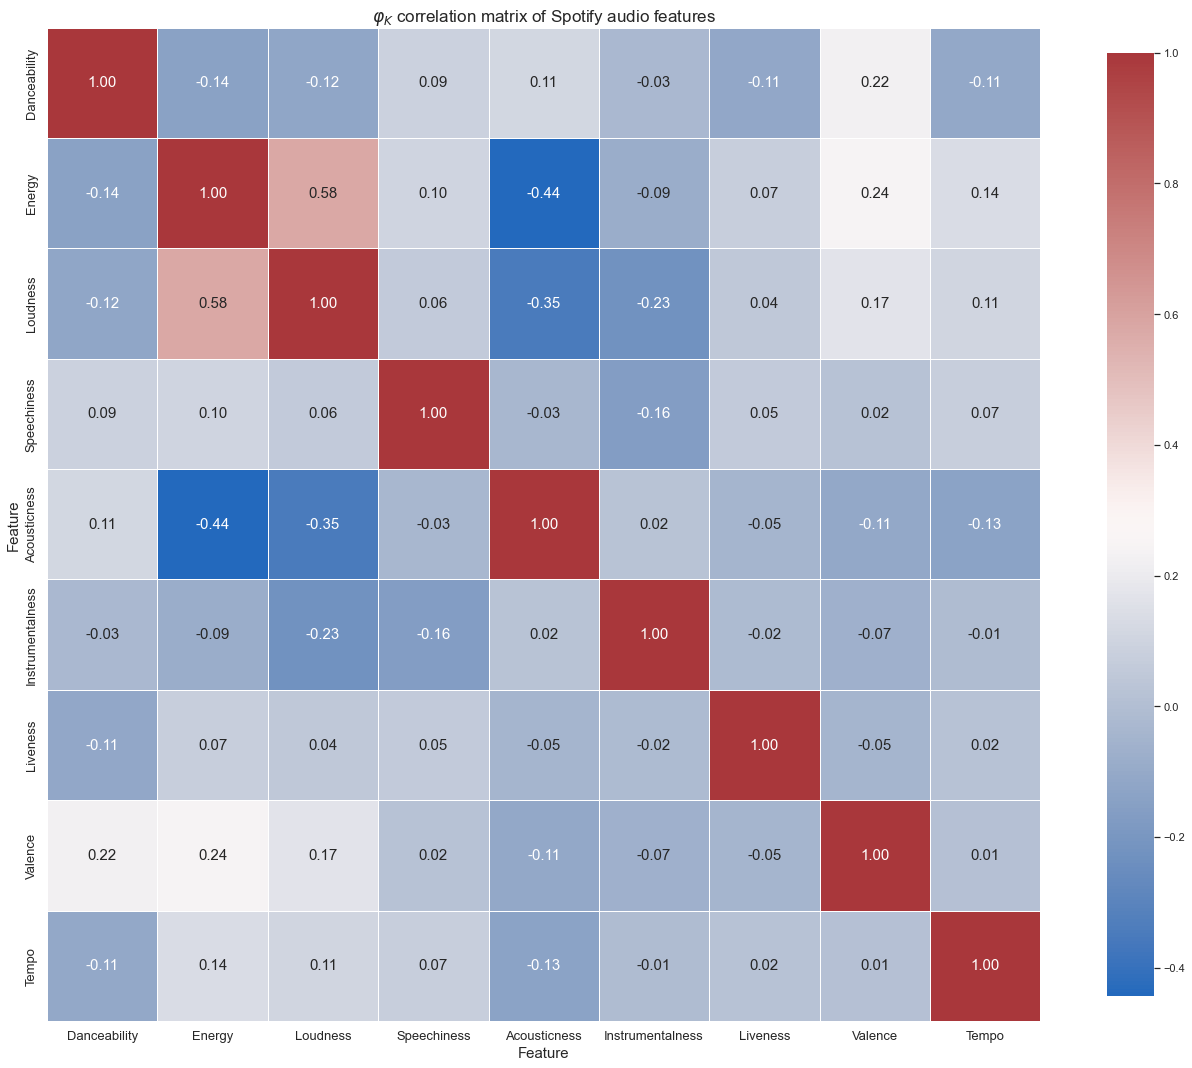

In [9]:
pearsons_corr_df = df[feature_cols].corr(method='kendall')
plt.figure(figsize=(19,15))
sns.heatmap(
    data=pearsons_corr_df,
    cmap='vlag',
    square=True,
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': 15},
    cbar=True,
    cbar_kws={'shrink': 0.95},
    xticklabels=[col.title() for col in feature_cols],
    yticklabels=[col.title() for col in feature_cols],
)
plt.title('$φ_K$ correlation matrix of Spotify audio features',fontsize=17)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

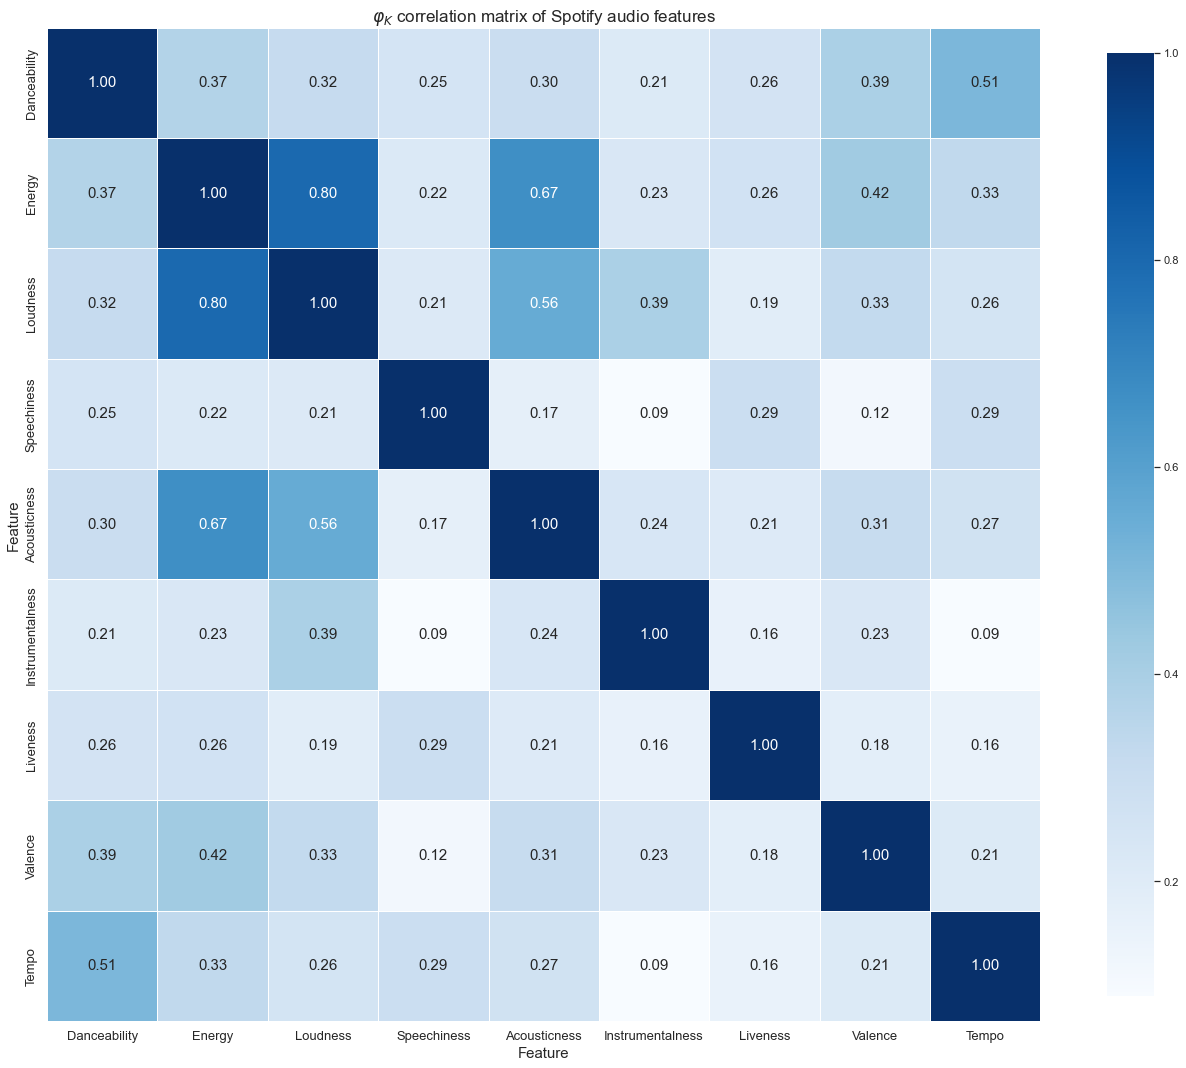

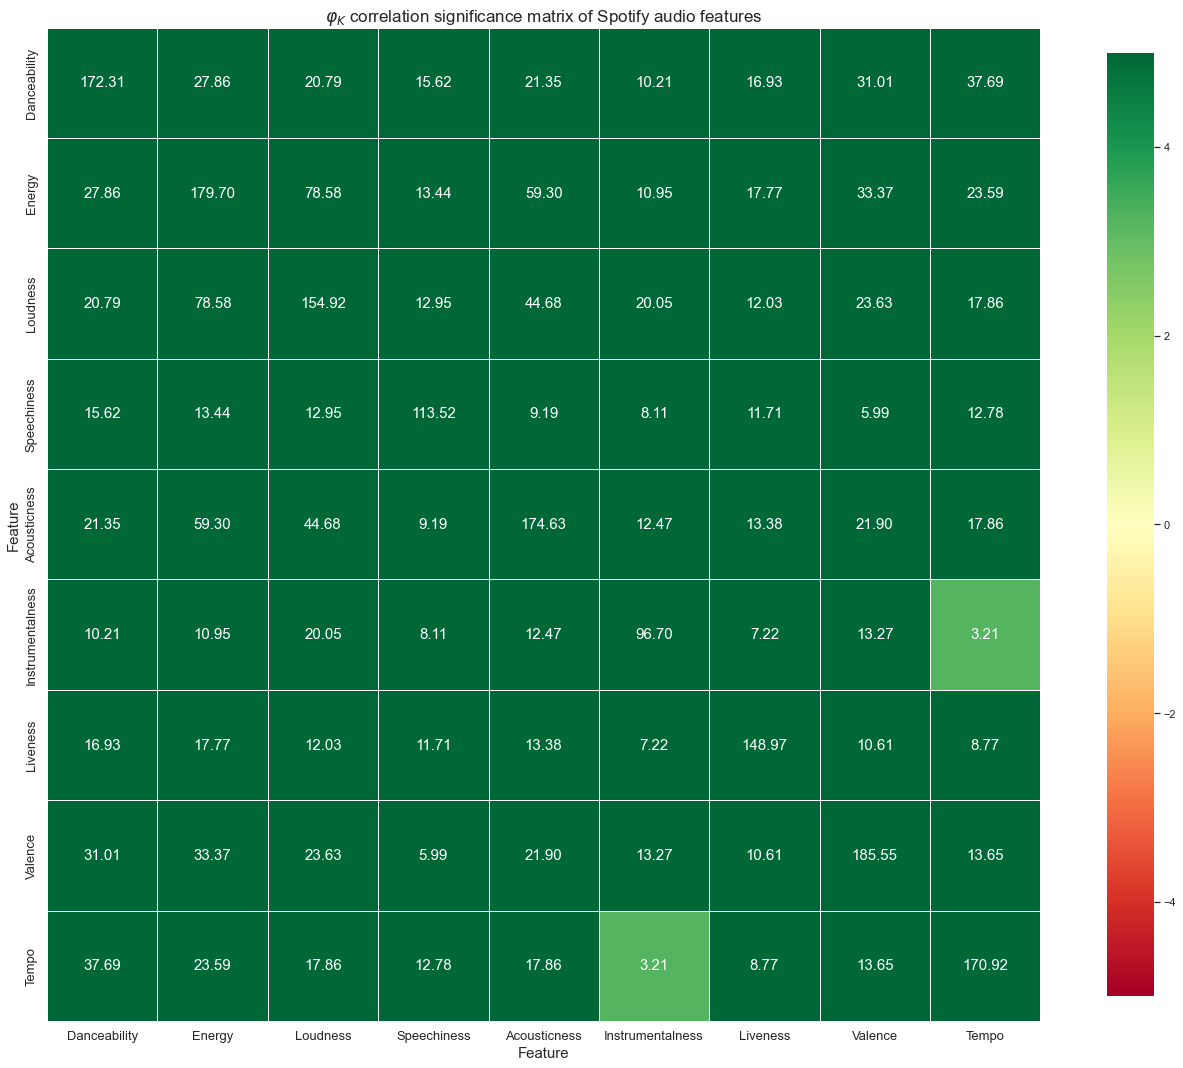

In [29]:
# Calculate and visualise Phi-k correlation values of audio feature columns
corr_df = df[feature_cols].phik_matrix(interval_cols=feature_cols)
corr_sig_df = df[feature_cols].significance_matrix(interval_cols=feature_cols)

plt.figure(figsize=(19,15))
sns.heatmap(
    data=corr_df,
    cmap='Blues',
    square=True,
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': 15},
    cbar=True,
    cbar_kws={'shrink': 0.95},
    xticklabels=[col.title() for col in feature_cols],
    yticklabels=[col.title() for col in feature_cols],
)
plt.title('$φ_K$ correlation matrix of Spotify audio features',fontsize=17)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

save_path = f'{FIG_SAVE_PATH}/phi_k_correlation_spotify_audio_features.png'
if not path.exists(save_path):
    plt.savefig(save_path, bbox_inches='tight')

plt.show()


plt.figure(figsize=(19,15))
sns.heatmap(
    data=corr_sig_df,
    cmap='RdYlGn',
    vmin=-5,
    vmax=5,
    square=True,
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': 15},
    cbar=True,
    cbar_kws={'shrink': 0.95},
    xticklabels=[col.title() for col in feature_cols],
    yticklabels=[col.title() for col in feature_cols],
)
plt.title('$φ_K$ correlation significance matrix of Spotify audio features', fontsize=17)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

save_path = f'{FIG_SAVE_PATH}/phi_k_correlation_significance_spotify_audio_features.png'
if not path.exists(save_path):
    plt.savefig(save_path, bbox_inches='tight')
    
plt.show()

In [26]:
global_correlation, global_labels = df[feature_cols].global_phik(interval_cols=feature_cols)
for c, l in zip(global_correlation, global_labels):
    print(l, c[0])

danceability 0.6142760242280971
energy 0.8657263622086561
loudness 0.8309057254761245
speechiness 0.40459891428672573
acousticness 0.674183350530888
instrumentalness 0.46803159779146963
liveness 0.4010755445946599
valence 0.5104043281966631
tempo 0.556535815813085


<AxesSubplot:>

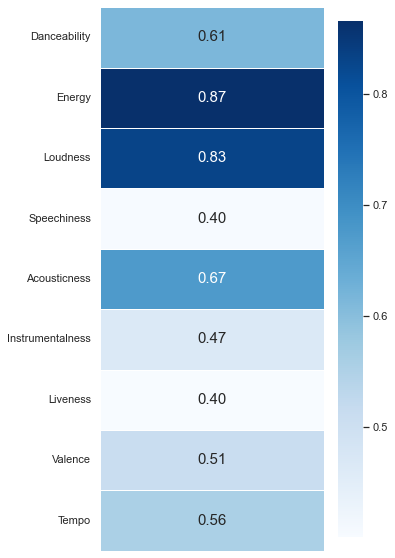

In [34]:
plt.figure(figsize=(5,10))
sns.heatmap(
    data=global_correlation,
    cmap='Blues',
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': 15},
    cbar=True,
    cbar_kws={'shrink': 0.95},
    xticklabels=[],
    yticklabels=[col.title() for col in feature_cols],)

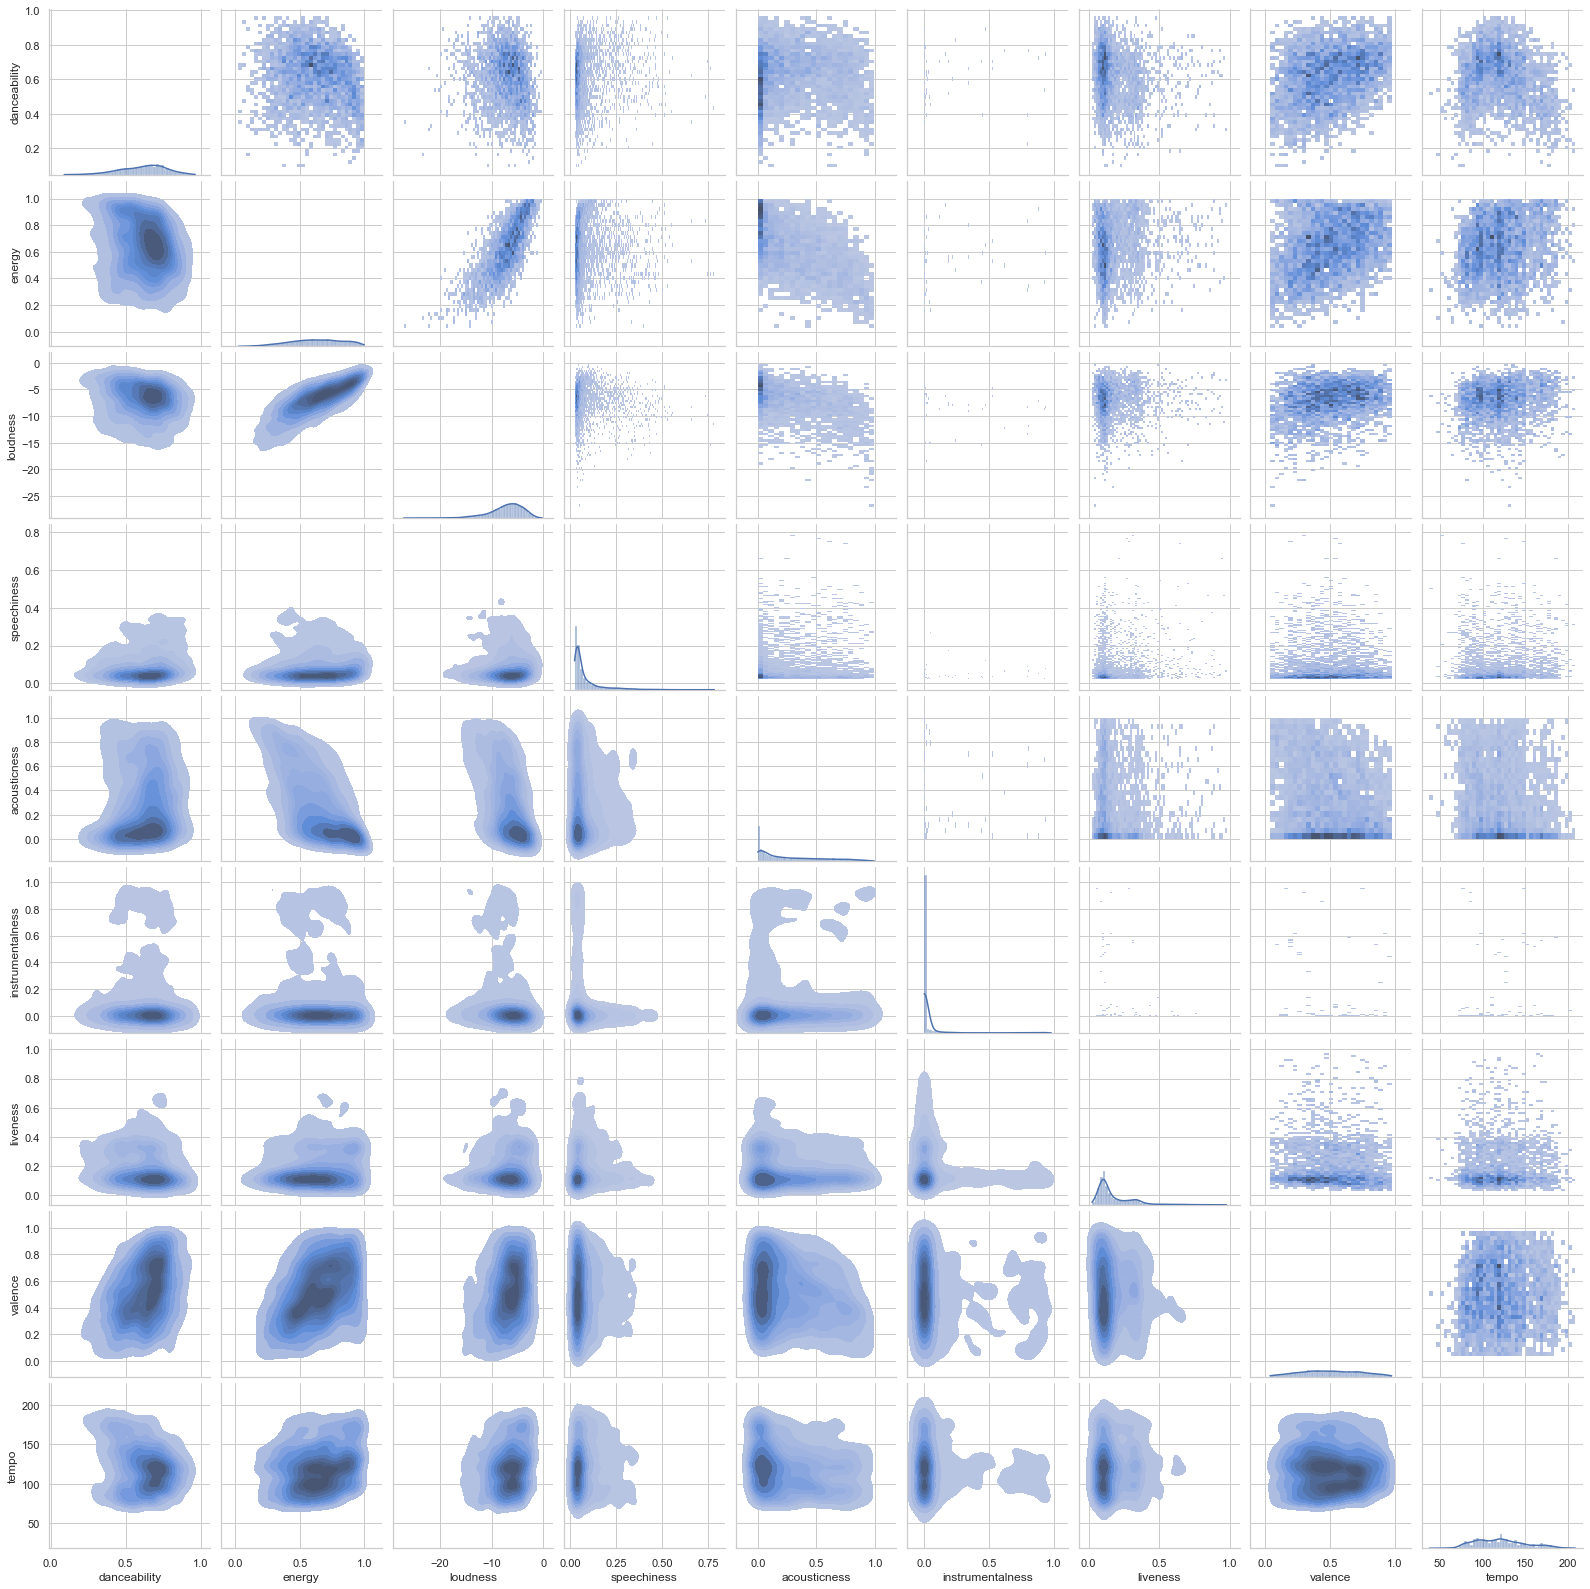

In [16]:
# Make pair plot with 2d hist plots on upper, KDE plots on lower, and univariate hist on diagonal 
g = sns.PairGrid(df[feature_cols])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, stat='count', bins=50)
g.tight_layout()

save_path = f"{FIG_SAVE_PATH}/track_feature_pair_plot_all_tracks.png"
if not path.exists(save_path):
    g.savefig()(save_path, bbox_inches='tight')

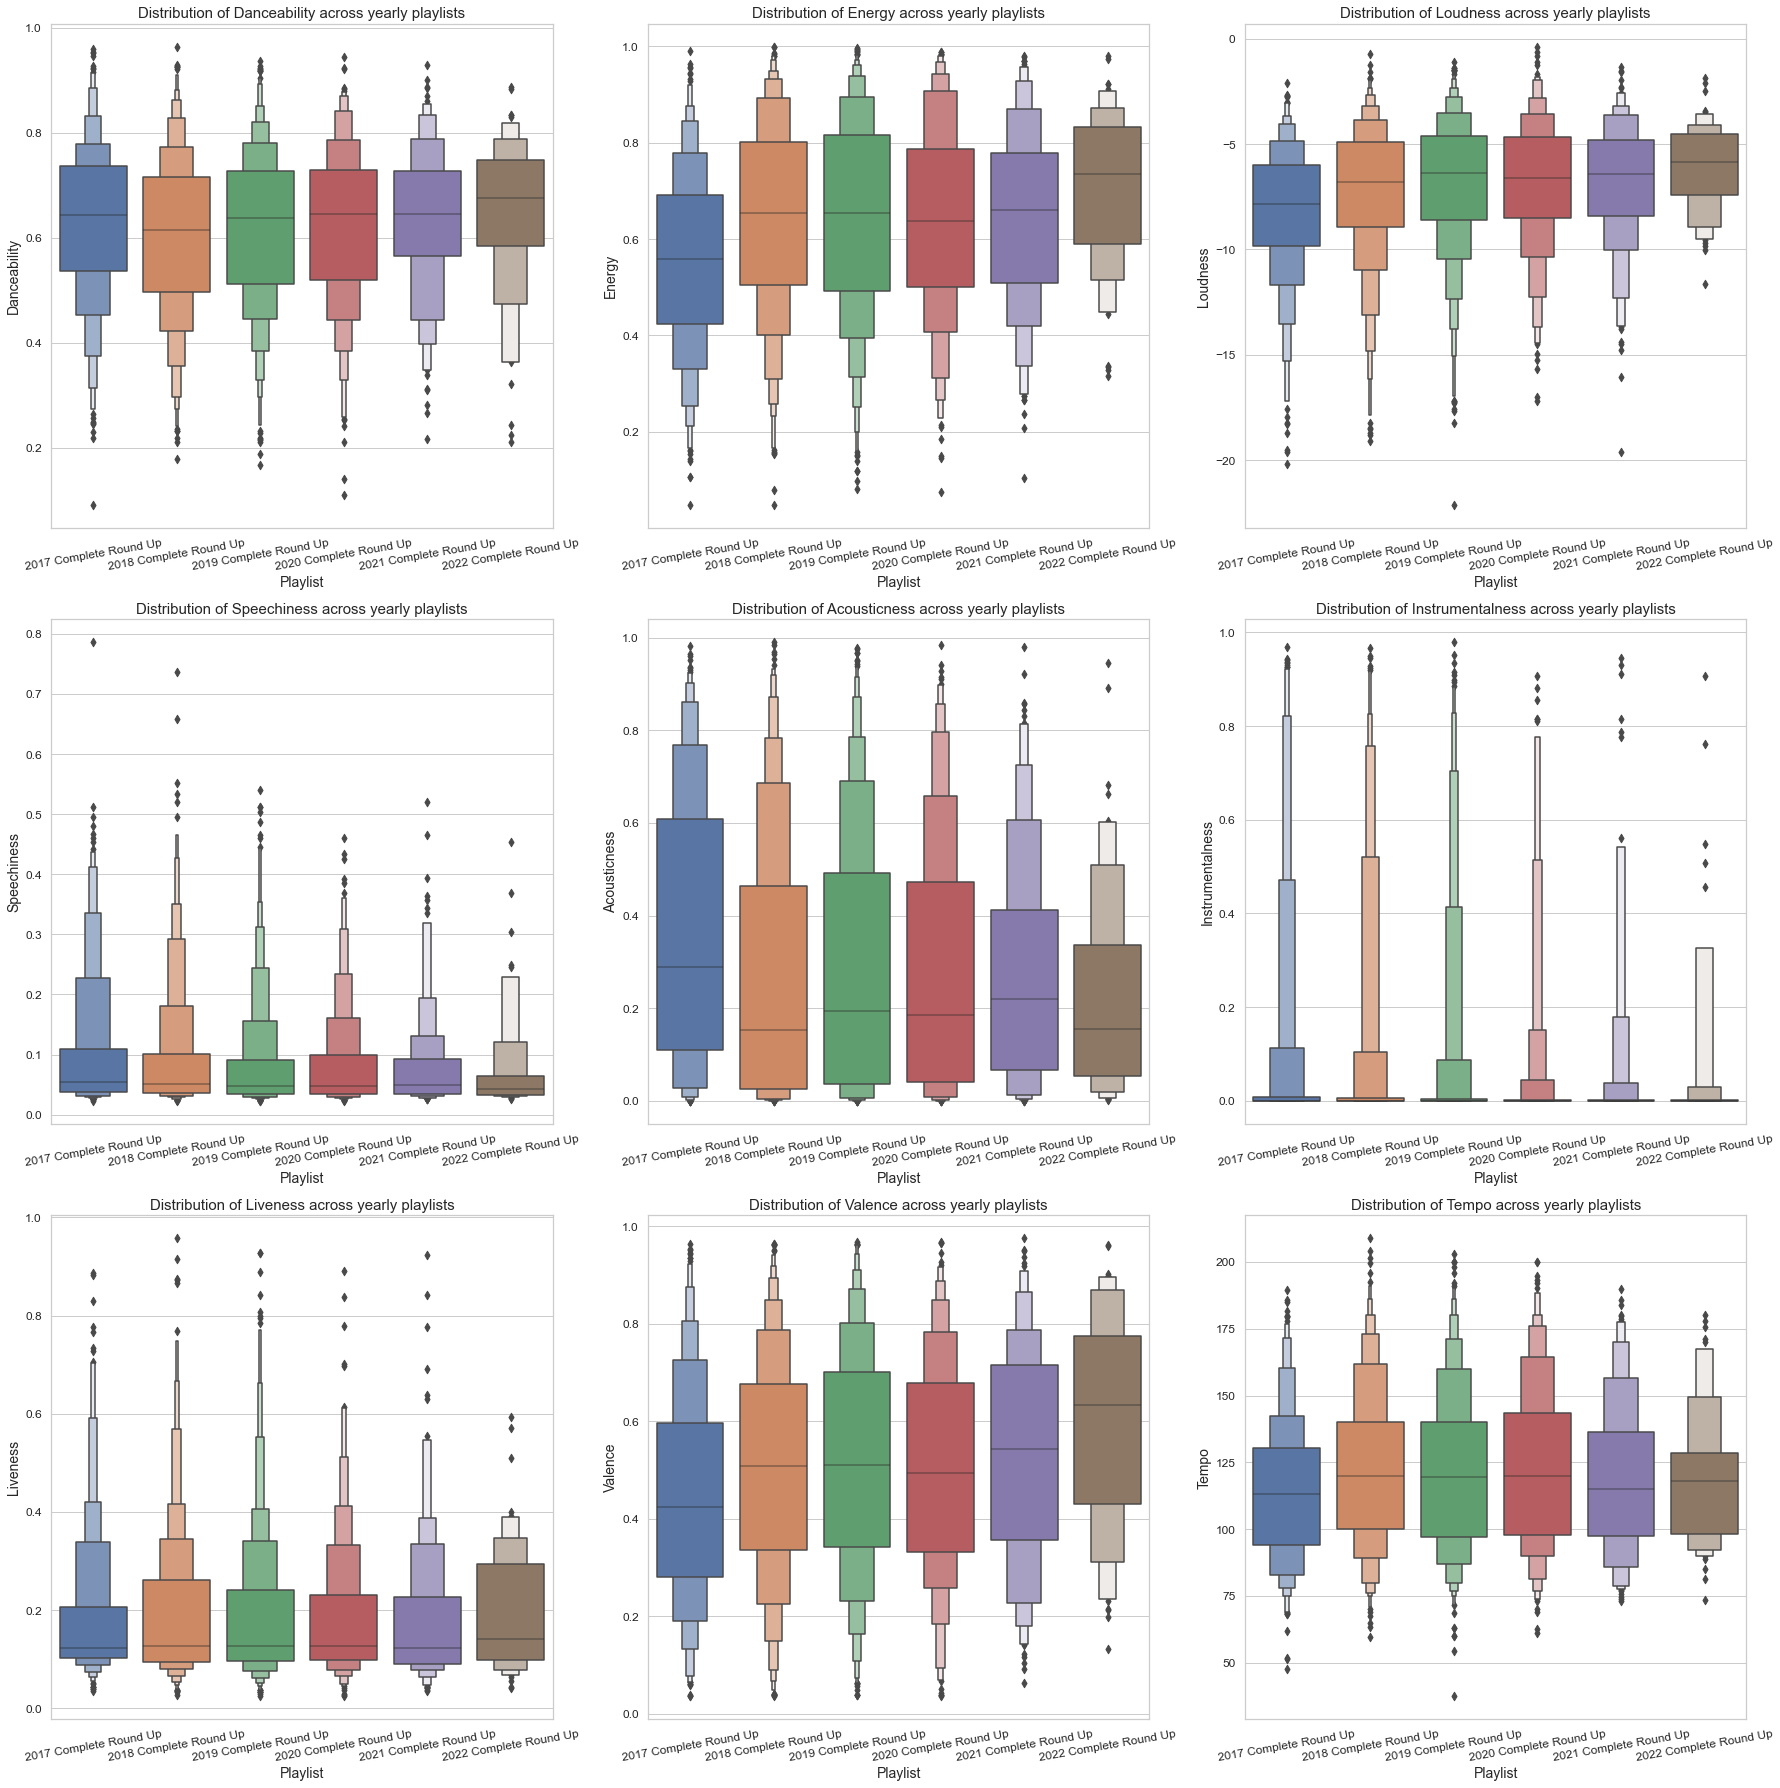

In [7]:
# Plot distribution of features for each of my '20XX Complete Round Up' playlists - how does my music change evolve across the years?
mask = df['playlist_name'].str.contains('Complete Round Up')

plt.figure(figsize=(25,25))
for idx, feat in enumerate(feature_cols, start=1):
    plt.subplot(3,3,idx)
    sns.boxenplot(y=feat, x='playlist_name', data=df[mask], order=[f'{year} Complete Round Up' for year in range(2017,2023)])
    plt.title(f'Distribution of {feat.capitalize()} across yearly playlists', fontsize=15)
    plt.ylabel(feat.capitalize(), fontsize=14)
    plt.xlabel('Playlist', fontsize=14)
    plt.xticks(rotation=10, fontsize=12)
    plt.yticks(fontsize=12)
    
plt.tight_layout()

save_path = f'{FIG_SAVE_PATH}/track_feature_dist_yearly_playlists.png'
if not path.exists(save_path):
    plt.savefig(save_path, bbox_inches='tight')

plt.show()

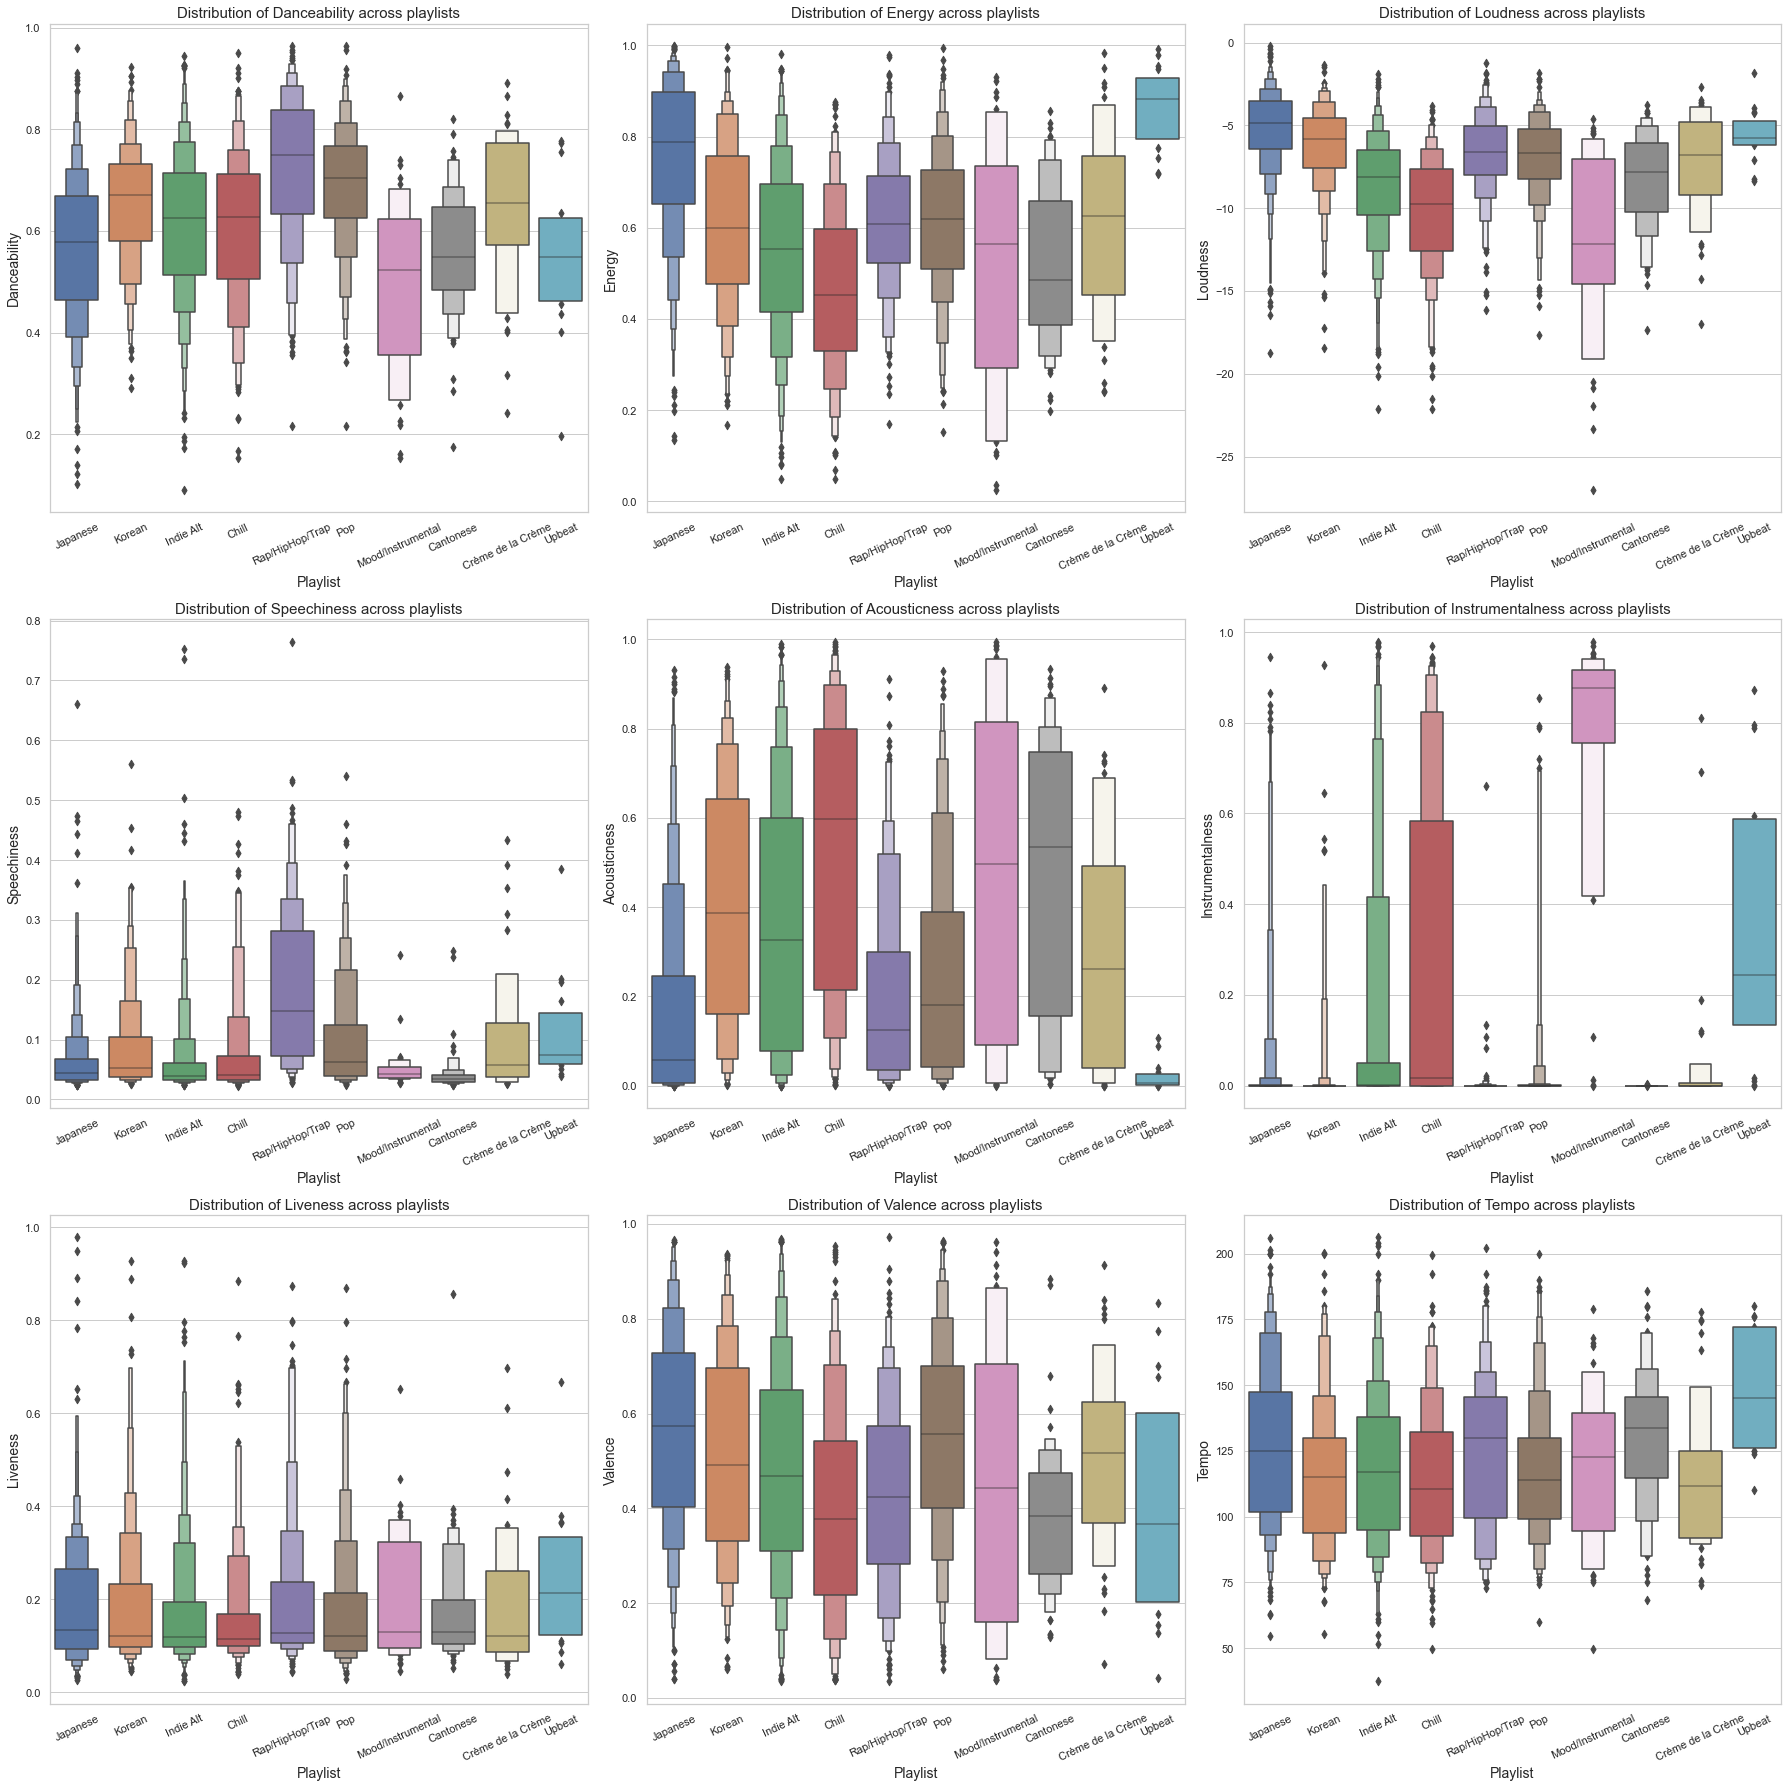

In [6]:
# Plot distribution for each of my language/genre based playlists
mask = (df['playlist_name'].isin([name for name in df['playlist_name'].unique() if ('Complete' not in name) and ('&' not in name) and ('playlist' not in name)]))

plt.figure(figsize=(25,25))
for idx, feat in enumerate(feature_cols, start=1):
    plt.subplot(3,3,idx)
    sns.boxenplot(y=feat, x='playlist_name', data=df[mask])
    plt.title(f'Distribution of {feat.capitalize()} across playlists', fontsize=15)
    plt.ylabel(feat.capitalize(), fontsize=14)
    plt.xlabel('Playlist', fontsize=14)
    plt.xticks(rotation=25)
    
plt.tight_layout()

save_path = f'{FIG_SAVE_PATH}/track_feature_dist_genre_playlists.png'
if not path.exists(save_path):
    plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [8]:
# Categorise tracks by when I added them to playlists -> granularity of 2 months
# This will give me a more granualar view of how my music taste evolves in 2 month periods
bi_month_year_map = {}
counter = 0

for year in range(2016,2023):
    for month in range(1,12,2):
        
        # Needed for string substitution
        if len(str(month)) < 2:
            _month = f'0{month}'
        else:
            _month = month

        if len(str(month+1)) == 2:
            _month_plus_1 = month+1
        else:
            _month_plus_1 = f'0{month+1}'
        
        # Take into account 2020 leap year for Feb end date
        if (year == 2020) and (month+1 == 2):
            last_date_month = MONTH_LAST_DATE_DICT[month+1] + 1
        else:
            last_date_month = MONTH_LAST_DATE_DICT[month+1]
        
        # Generate date mask for 2 month period
        date_mask = (
            (df['playlist_date_added'] >= pd.Timestamp(f'{year}-{_month}-01T00:00:00+0000'))
            & (df['playlist_date_added'] <= pd.Timestamp(f'{year}-{_month_plus_1}-{last_date_month}T23:59:59+0000'))
        )
        
        # Make a mapping of counter -> period name
        bi_month_year_map[counter] =  f'{MONTH_NAME_DICT[month]} & {MONTH_NAME_DICT[month+1]} {year}'
        
        # Set 'bi_month_year' for period as counter, makes it easy to sort the dataframe
        # Can use the mapping when we want the period names
        df.loc[date_mask, 'bi_month_year'] = counter
        
        # Increment the counter
        counter += 1

In [9]:
# Perform a group by aggregation to get the median values of features by each 'bi_month_year' period
agg_df = (
    df
    .groupby(by='bi_month_year')
    .agg({
        'danceability': 'median',
        'energy': 'median',
        'key': 'median',
        'loudness': 'median',
        'speechiness': 'median',
        'acousticness': 'median',
        'instrumentalness': 'median',
        'liveness': 'median',
        'valence': 'median',
        'tempo': 'median'
    })
    .reset_index()
)

agg_df['bi_month_year'] = agg_df['bi_month_year'].astype(int)

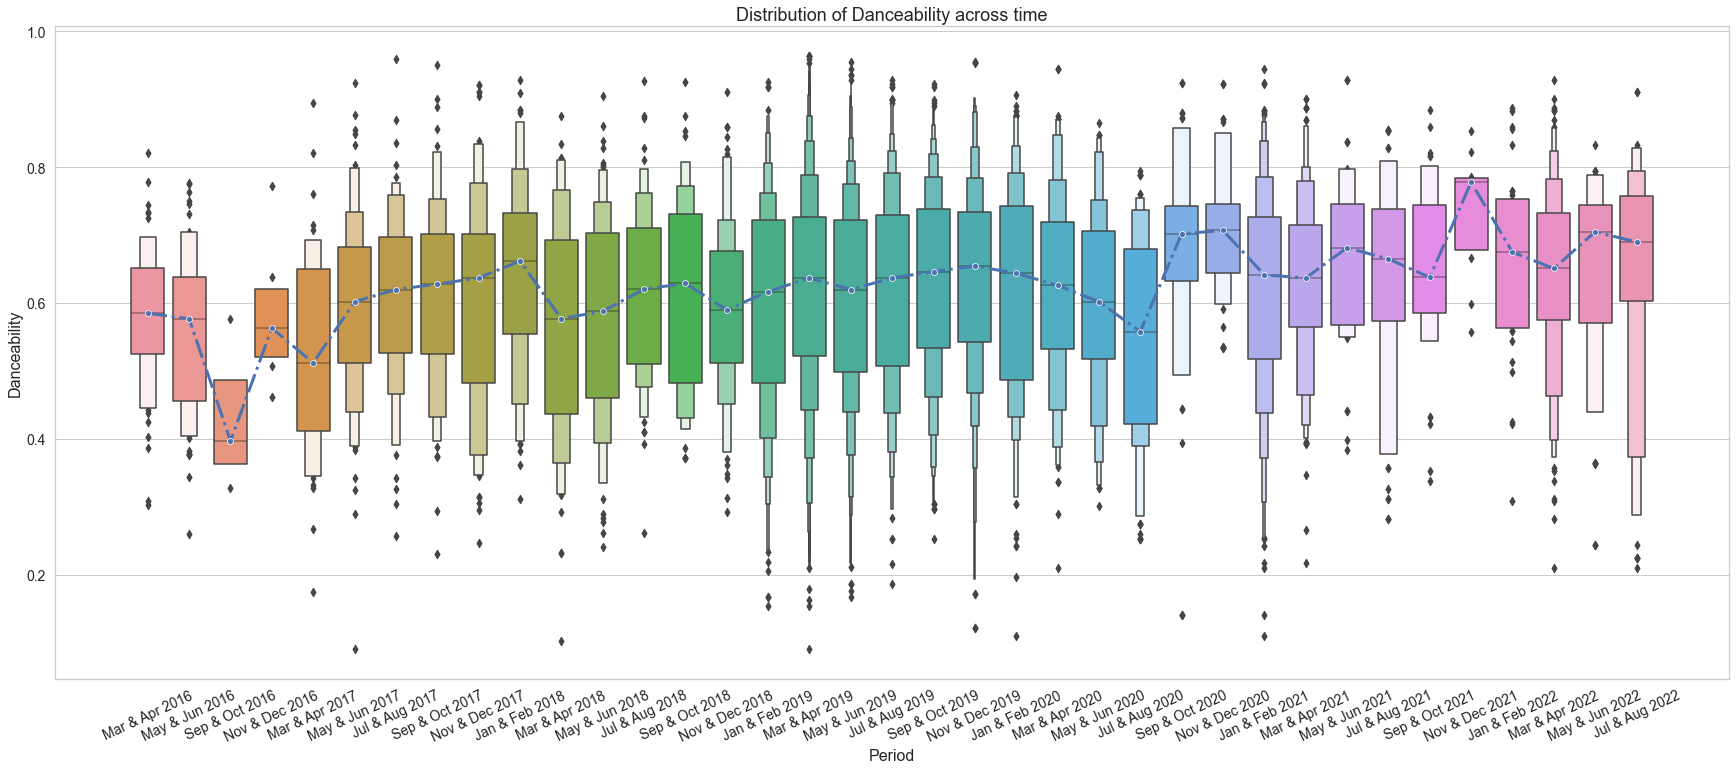

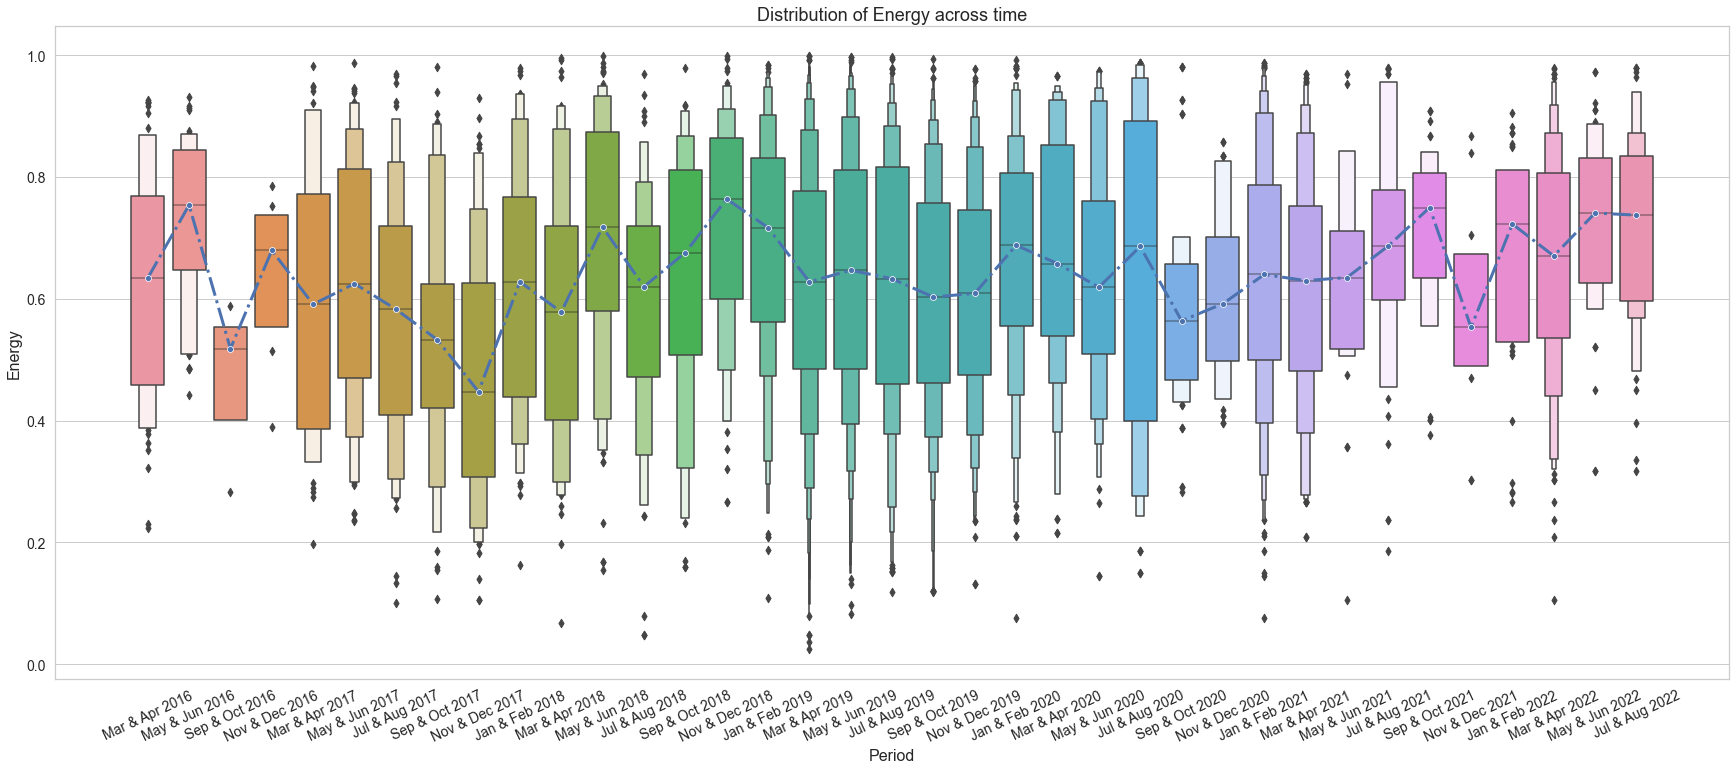

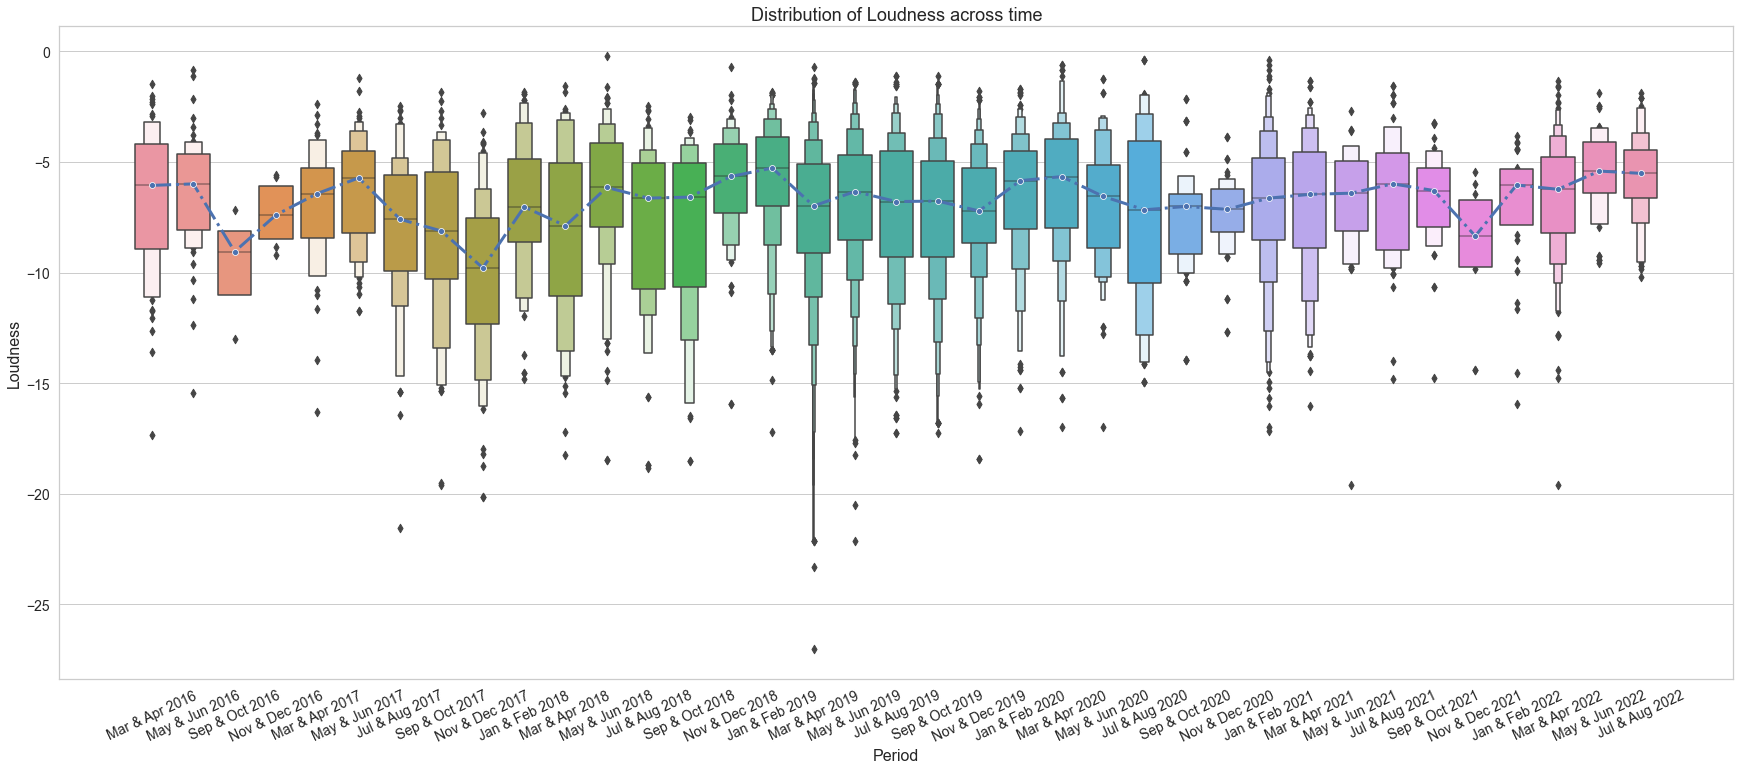

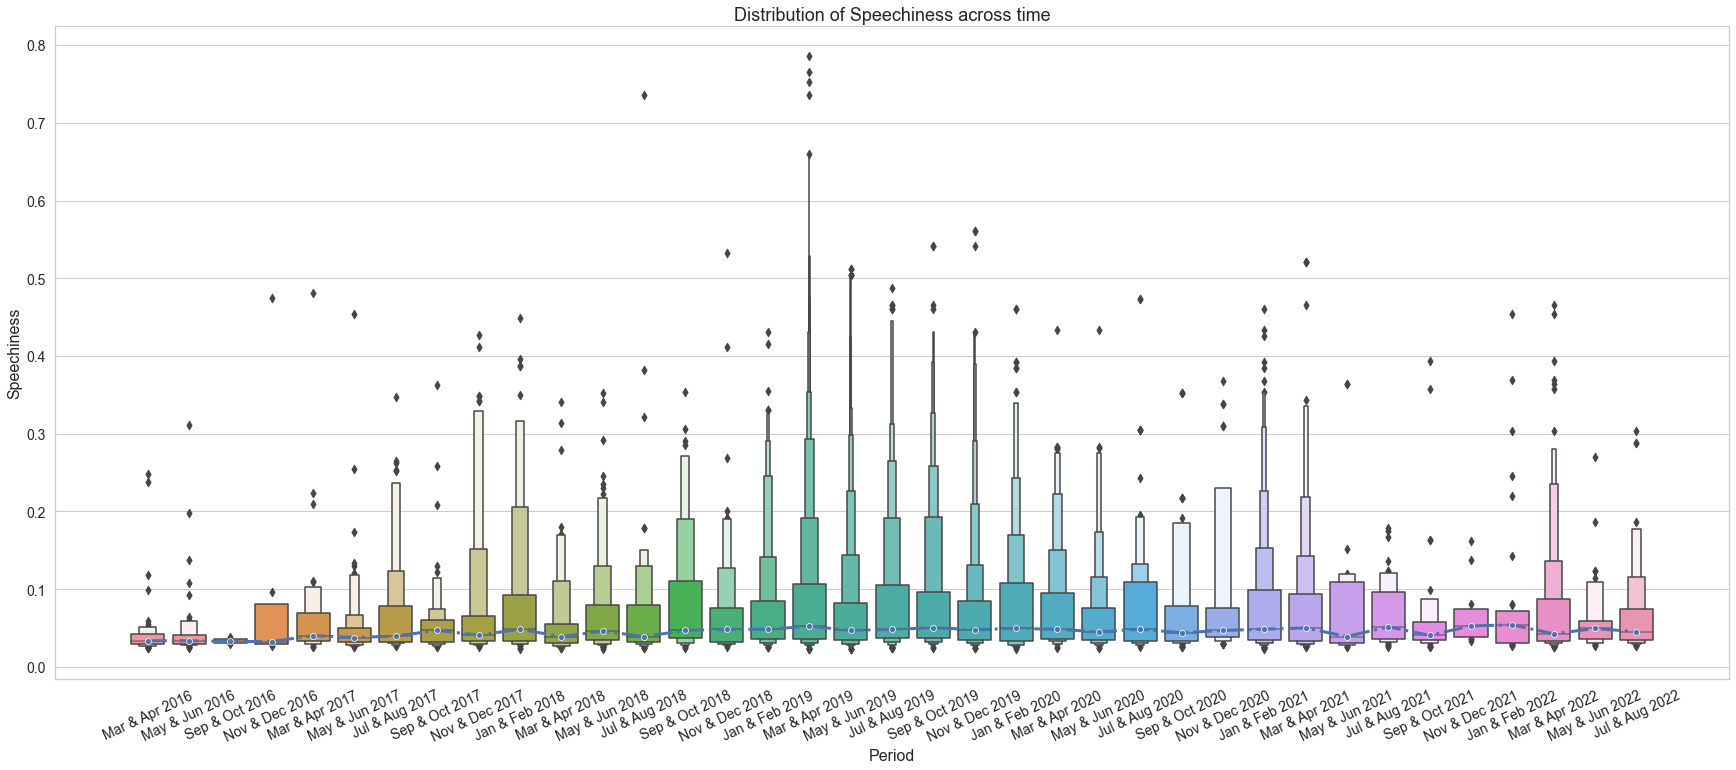

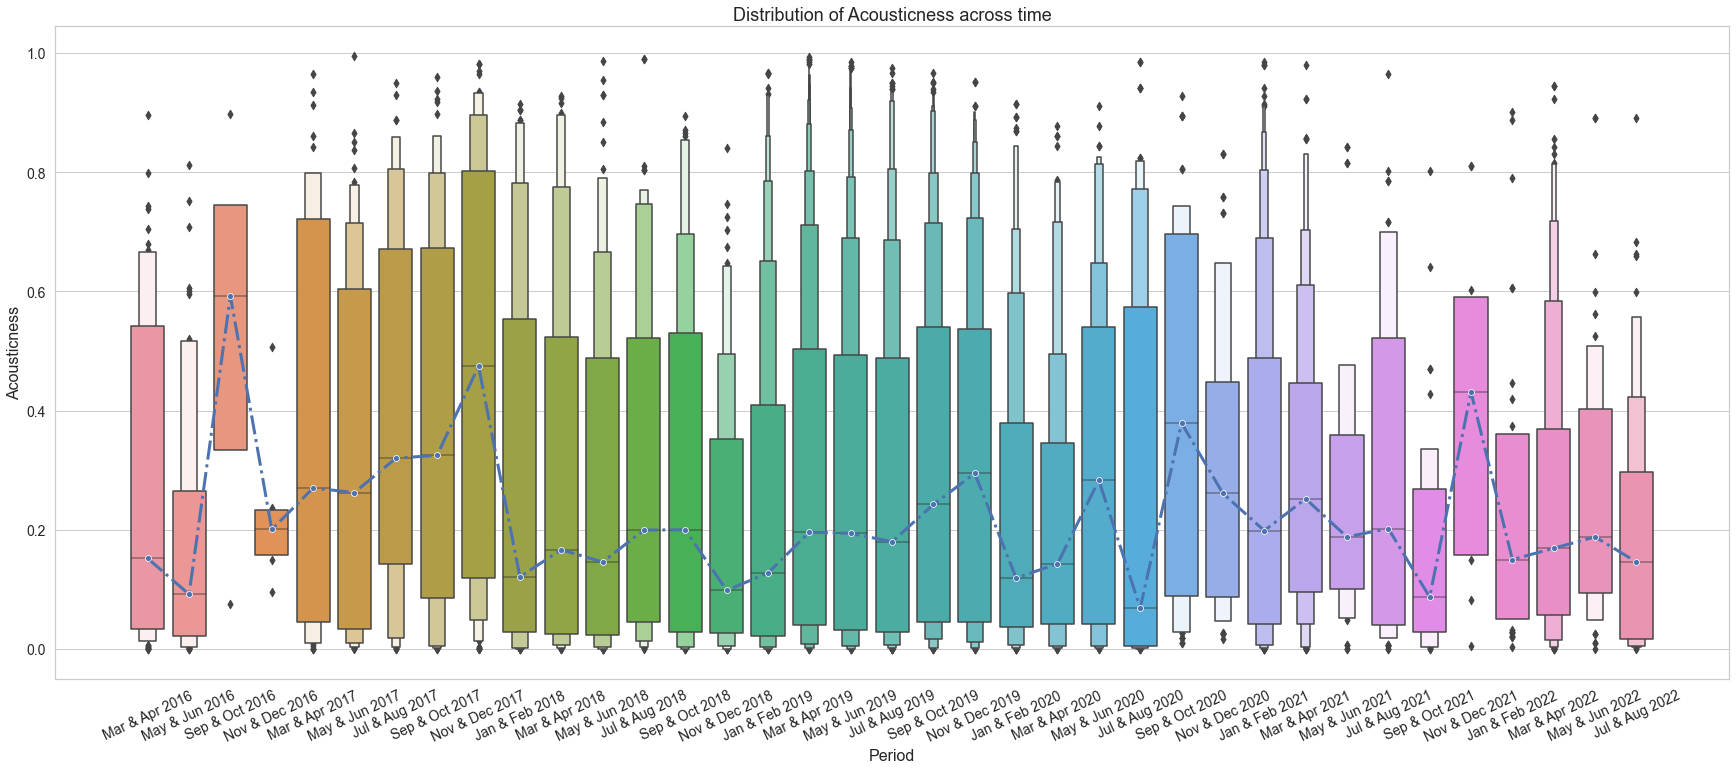

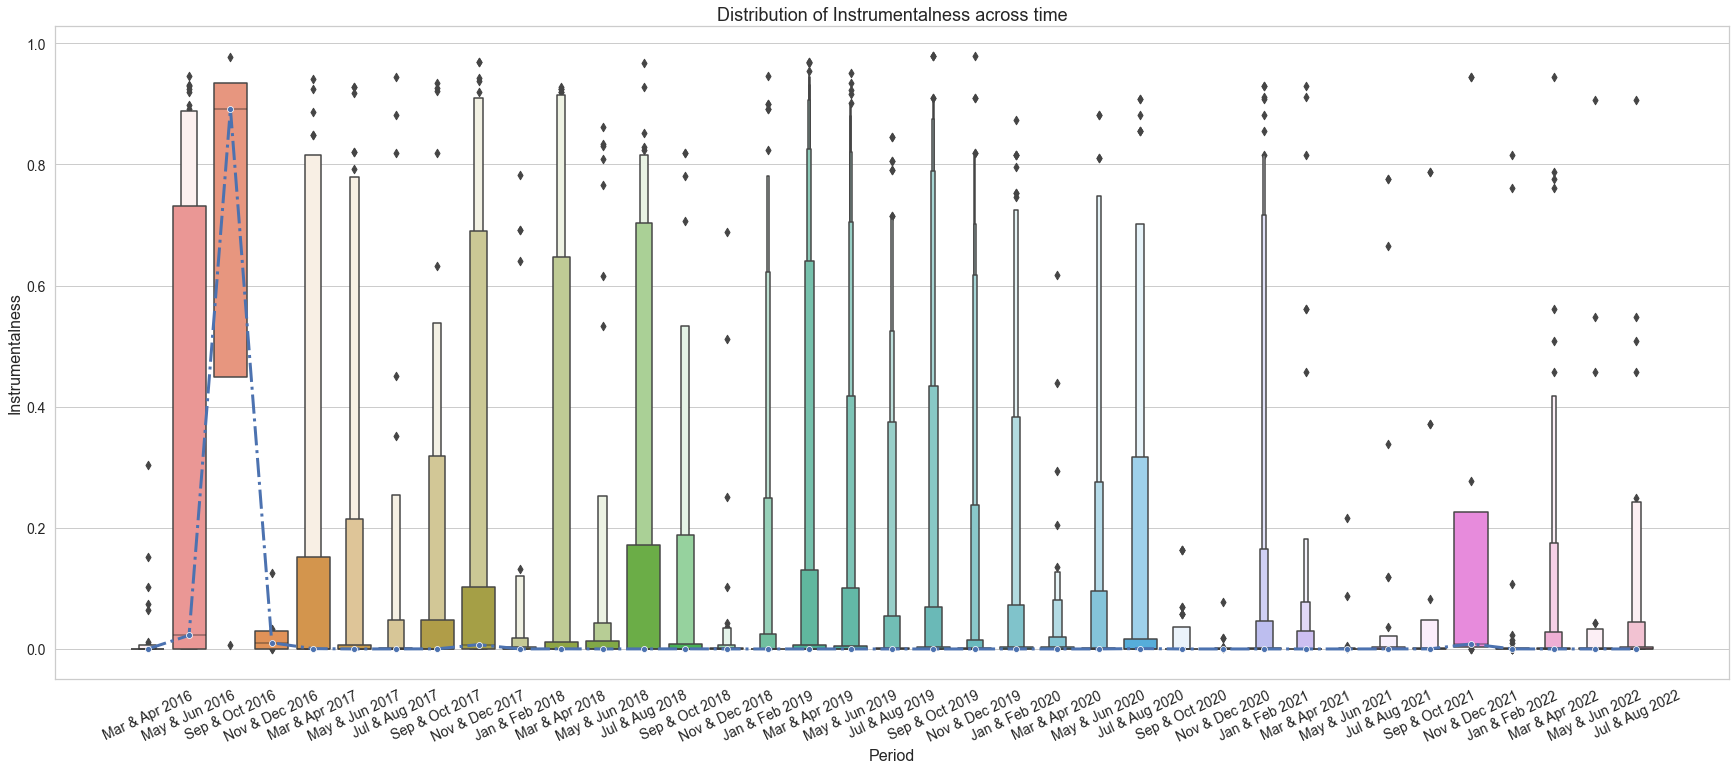

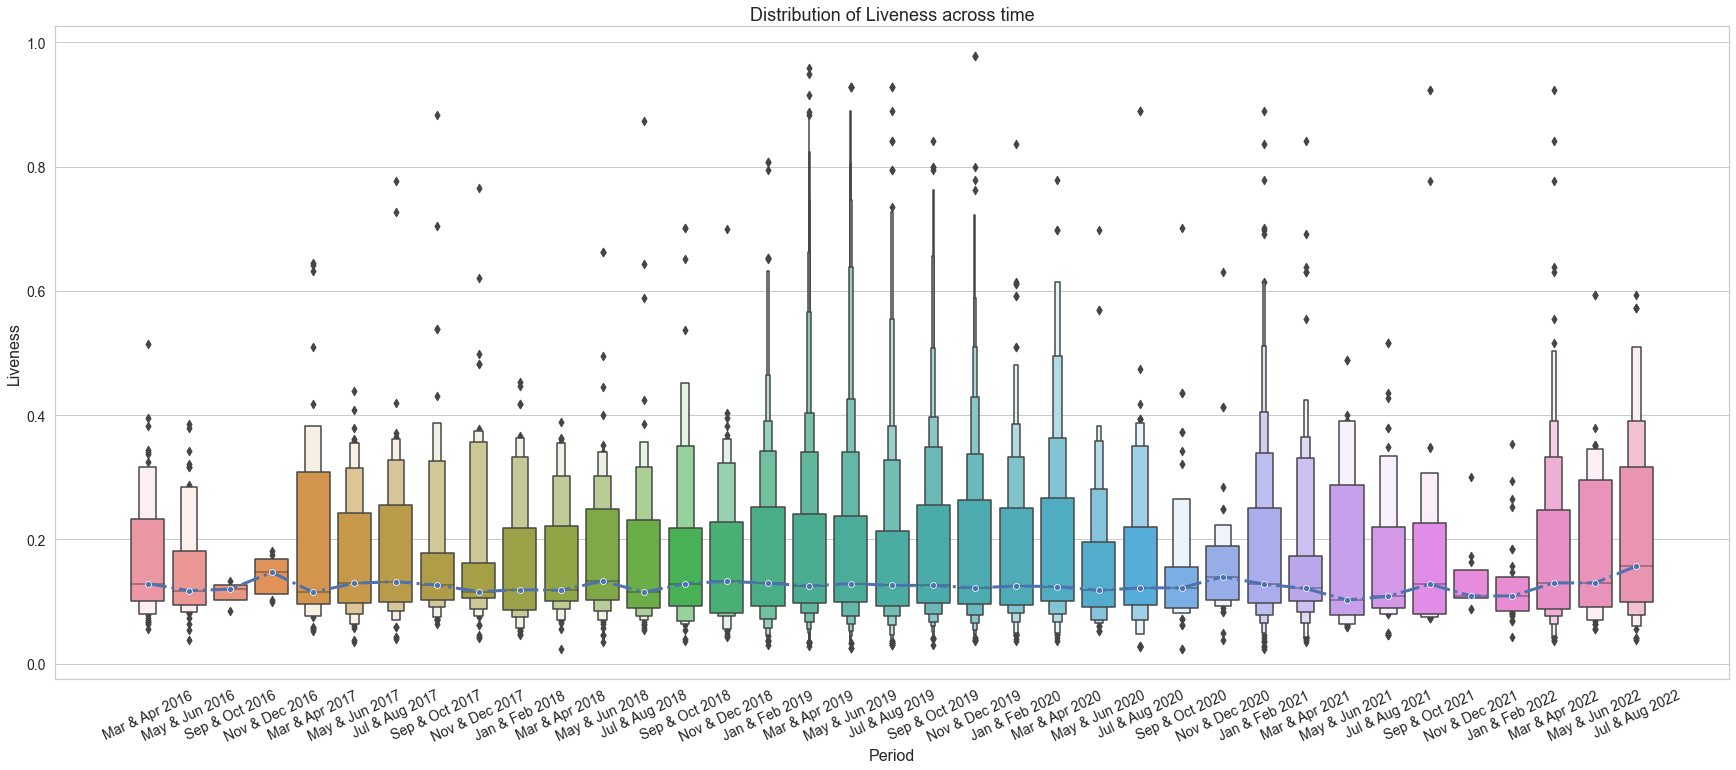

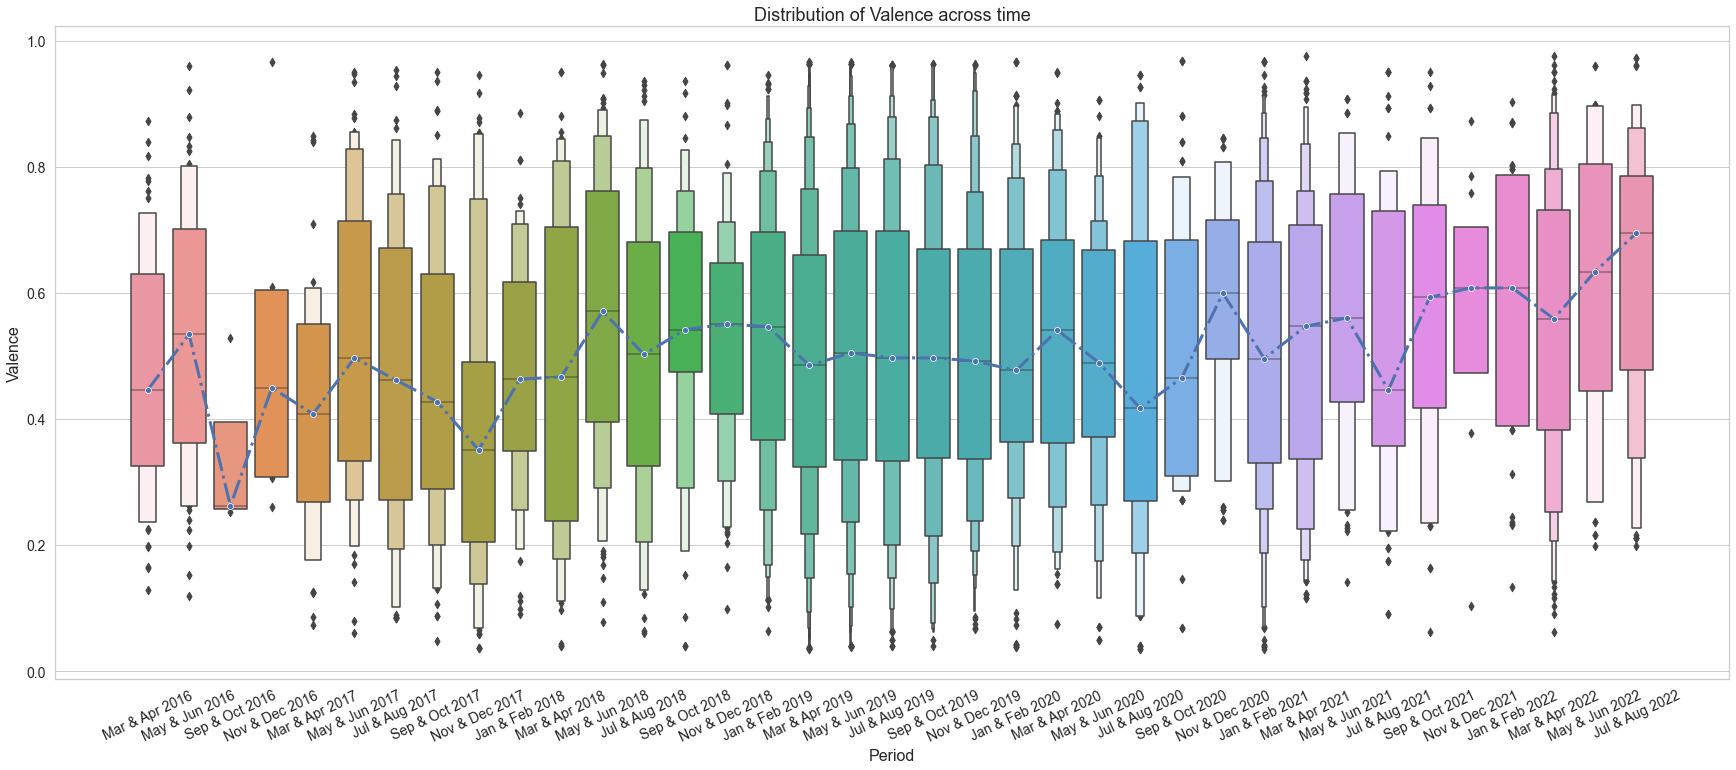

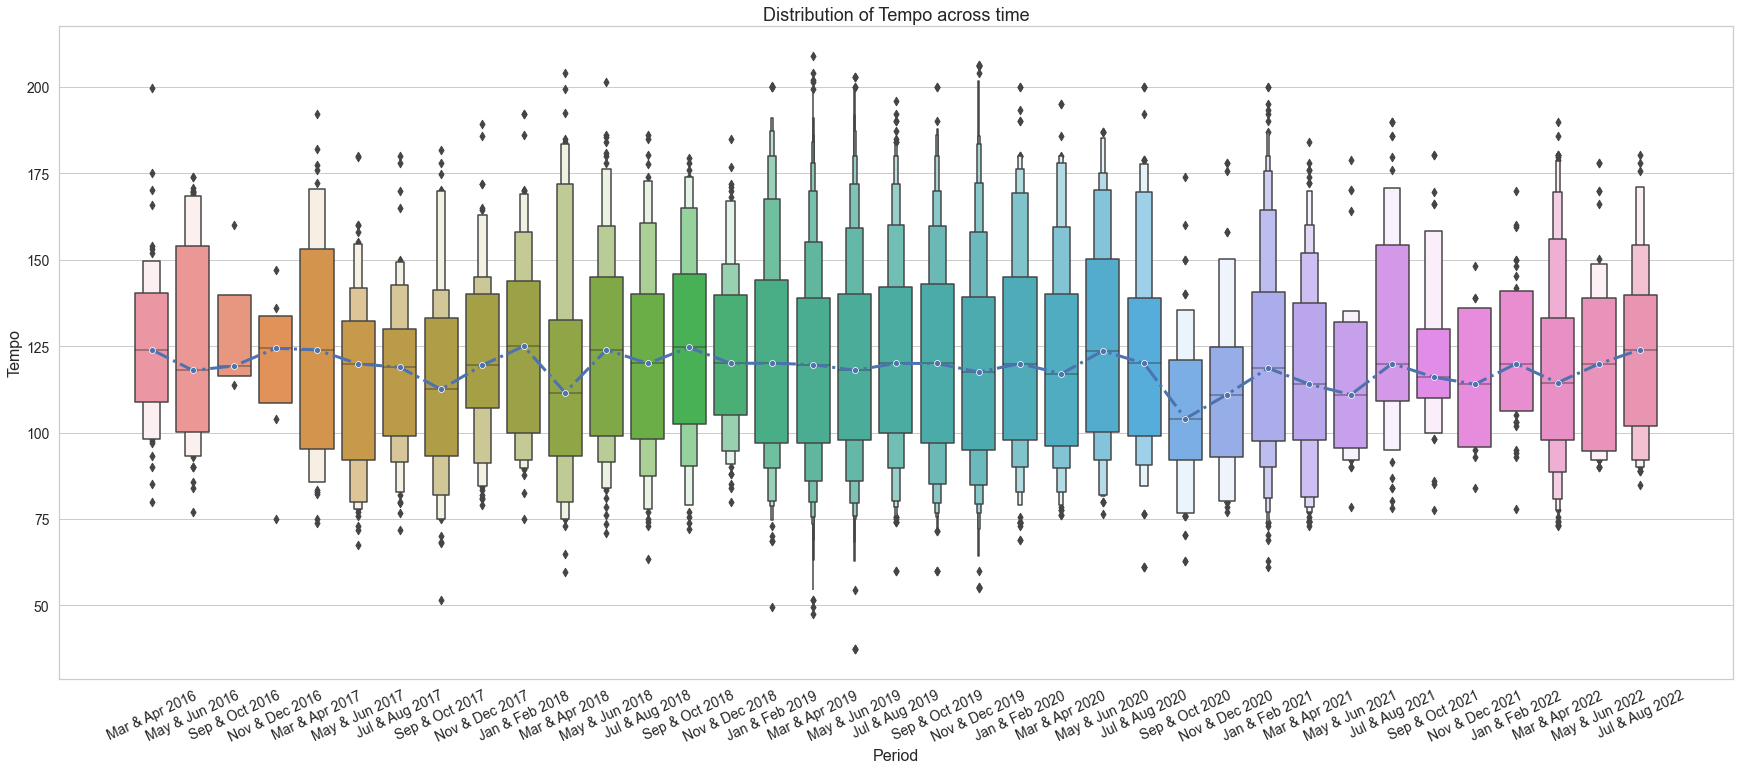

In [10]:
# Make boxen plots for each track feature across all 2-month periods
# Can I notice any changes in music taste due to life events?
for feat in feature_cols:
    plt.figure(figsize=(30,12))
    
    sns.boxenplot(y=feat, x='bi_month_year', data=df.sort_values(by=['bi_month_year']))
    sns.lineplot(y=agg_df[feat], x=range(len(agg_df)), marker='o', linestyle='-.', linewidth=3)
    
    plt.title(f'Distribution of {feat.capitalize()} across time', fontsize=18)
    plt.ylabel(feat.capitalize(), fontsize=16)
    plt.xlabel('Period', fontsize=16)
    plt.xticks(ticks=range(df['bi_month_year'].nunique()) ,labels=[bi_month_year_map.get(key) for key in df.sort_values(by=['bi_month_year'])['bi_month_year'].unique()], rotation=25, fontsize=14)
    plt.yticks(fontsize=14)
    
    save_path = f'{FIG_SAVE_PATH}/track_{feat}_dist_2016-2022.png'
    if not path.exists(save_path):
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

In [182]:
agg_df_cp = (
    agg_df[['danceability', 'valence', 'energy', 'acousticness']]
    .copy()
    .T
    .rename(columns={k:v for k,v in bi_month_year_map.items()})
    .reset_index()
)

melted_agg_df = pd.DataFrame()
for col in agg_df_cp.columns:
    if col == 'index':
        continue
    tmp_df = agg_df_cp[['index', col]].rename(columns={col: 'values'})
    tmp_df['period'] = col
    melted_agg_df = pd.concat([melted_agg_df, tmp_df])

# melted_agg_df = melted_agg_df.reset_index(drop=True)
melted_agg_df['index'] = pd.Categorical(melted_agg_df['index'])

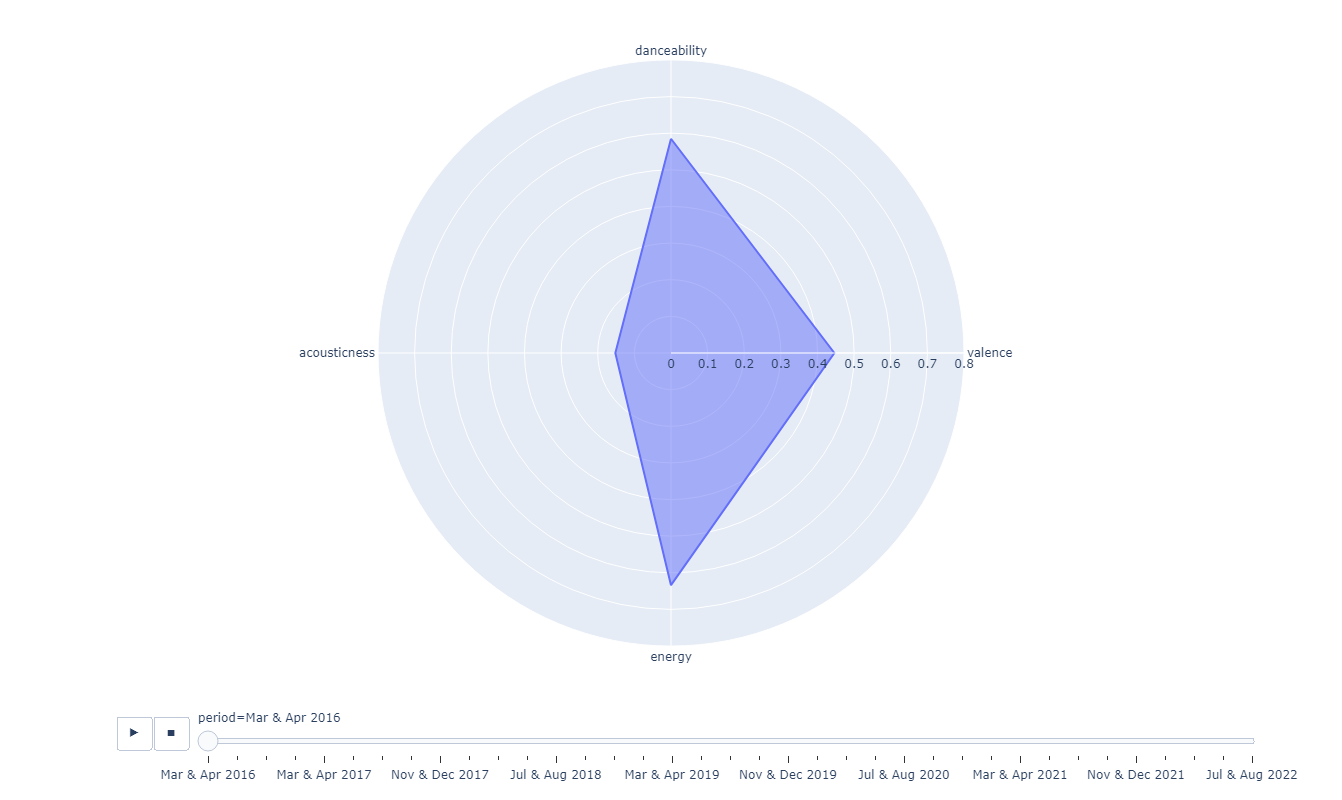

In [185]:
fig = px.line_polar(
    melted_agg_df,
    r='values',
    theta='index',
    animation_frame='period',
    animation_group='index',
    line_close=True,
    width=800,
    height=800
)

fig.update_traces(fill='toself')

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.8]
    )),
  showlegend=False
)

save_path = f"{FIG_SAVE_PATH}/track_features_radar_chart_2_monthly_periods.html"
if not path.exists(save_path):
    fig.write_html(f"{FIG_SAVE_PATH}/track_features_radar_chart_2_monthly_periods.html")
    
fig.show()

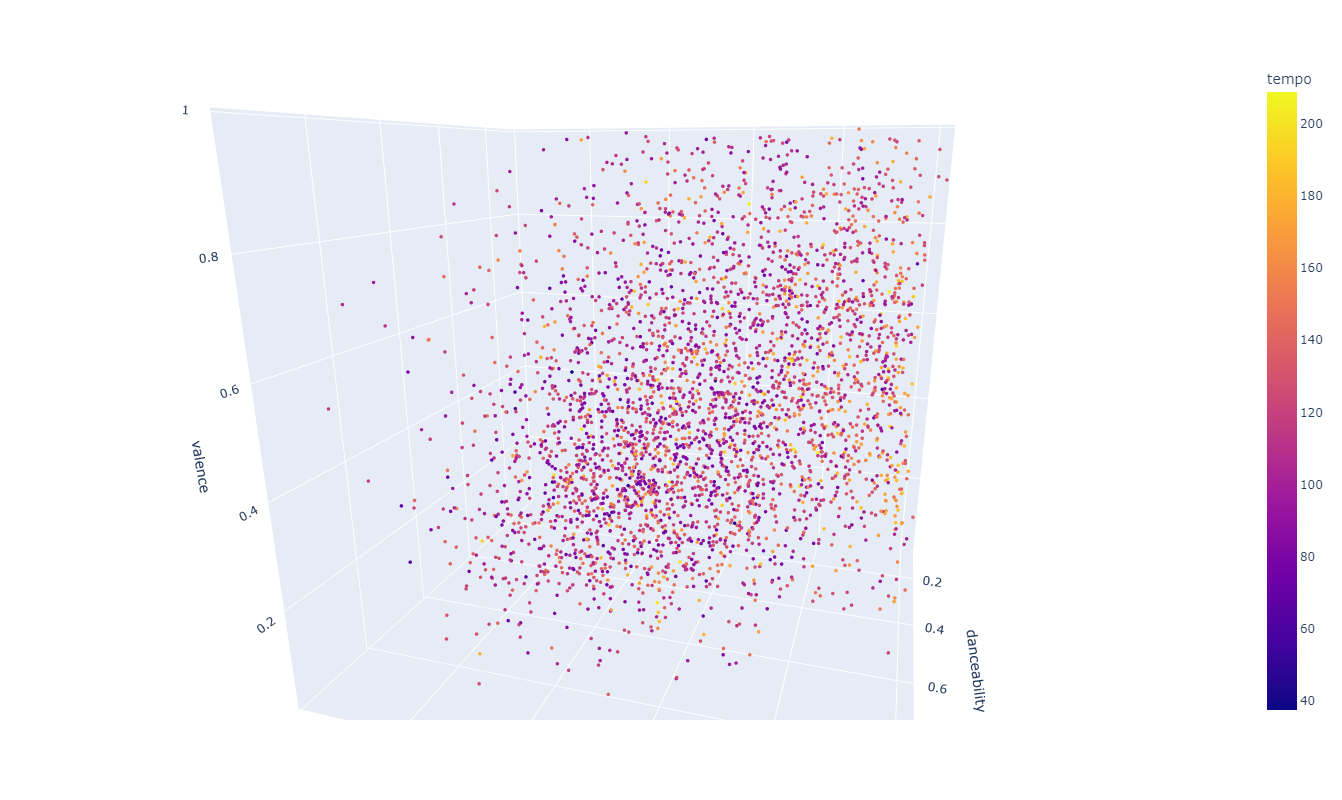

In [10]:
fig = px.scatter_3d(
    df.drop_duplicates(subset=['id']),
    x='danceability',
    y='energy',
    z='valence',
    color='tempo',
    width=800,
    height=800
)

fig.update_traces(
    marker=dict(size=2),
    selector=dict(mode='markers')
)

fig.show()

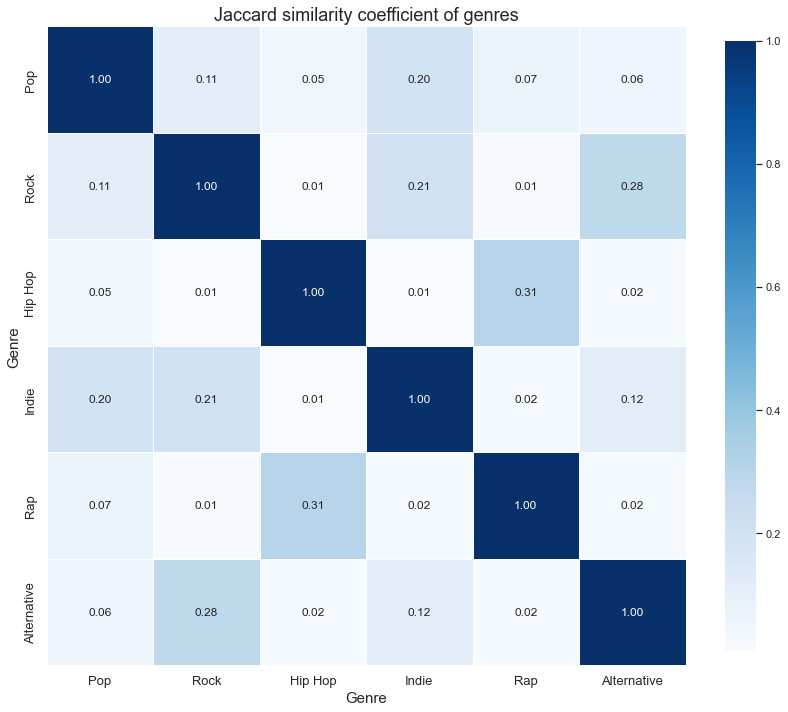

In [13]:
# Initalise array of zeros to store results in
score_arr = np.zeros((len(genres), len(genres)))

# Calculate Jaccard similarity score for pairs of genres of tracks
# Tells us the proportion of co-occurance of genres for tracks are classified either or both genres
for idx1, genre1 in enumerate(genres):
    for idx2, genre2 in enumerate(genres):
        score_arr[idx1][idx2] = jaccard_score(df[genre1] == 1, df[genre2] == 1)

# Plot results
plt.figure(figsize=(12,10))
sns.heatmap(
    data=score_arr,
    cmap='Blues',
    robust=True,
    square=True,
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': 12},
    cbar=True,
    cbar_kws={'shrink': 0.95},
    xticklabels=[' '.join(g.split('_')).title() for g in genres],
    yticklabels=[' '.join(g.split('_')).title() for g in genres],
)
plt.title('Jaccard similarity coefficient of genres', fontsize=18)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Genre', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

save_path = f'{FIG_SAVE_PATH}/jaccard_similary_coeffs_genres.png'
if not path.exists(save_path):
    plt.savefig(save_path, bbox_inches='tight')

plt.show()

pop,indie
rock,indie
hip_hop,rap
rock,alternative
indie,alternative
pop,rock


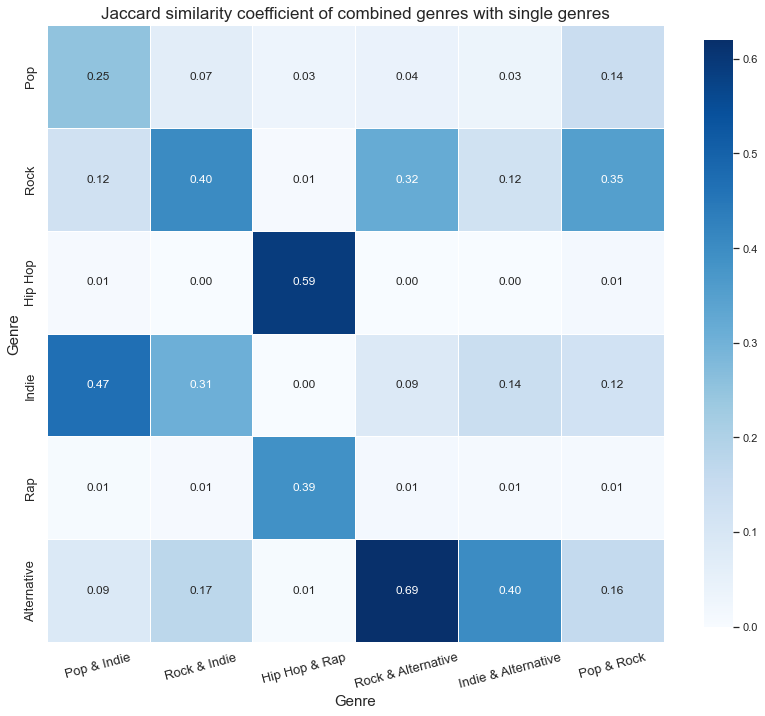

In [14]:
# Let's find out 'correlation' between combined genres (e.g. tracks that are assigned both pop and rock genres) with single genres (e.g. indie)

# First is to get the combined genres we're interested in
# We don't want permutations, i.e. we treat pop & rock and rock & pop as the same thing
# We also want to only get combined genres that have a similarity score of > 0.1 for the two individual genres
rec_set = set()
for genre1 in genres:
    for genre2 in genres:
        if genre1 == genre2:
            continue
        elif (f"{genre1},{genre2}" in rec_set) or (f"{genre2},{genre1}" in rec_set):
            continue
        else:
            if jaccard_score(df[genre1] == 1, df[genre2] == 1) < 0.1:
                continue
            else:
                rec_set.add(f"{genre1},{genre2}")

# Initalise array of zeros to store results in 
score_arr = np.zeros((len(rec_set), len(genres)))


# Calculate Jaccard similarity score for combined genres and individual genres of tracks
for idx1, comb_genre in enumerate(list(rec_set)):
    print(comb_genre)
    comb_genre1, comb_genre2 = comb_genre.split(',')
    for idx2, genre in enumerate(genres):
        score_arr[idx1][idx2] = jaccard_score(((df[comb_genre1] == 1) & (df[comb_genre2] == 1)), df[genre] == 1)

# Plot results
plt.figure(figsize=(12,10))
sns.heatmap(
    data=score_arr.T,
    cmap='Blues',
    robust=True,
    square=True,
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': 12},
    cbar=True,
    cbar_kws={'shrink': 0.95},
    xticklabels=[' '.join(' & '.join(g.split(',')).split('_')).title() for g in list(rec_set)],
    yticklabels=[' '.join(g.split('_')).title() for g in genres],
)
plt.title('Jaccard similarity coefficient of combined genres with single genres', fontsize=17)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Genre', fontsize=15)
plt.xticks(fontsize=13,rotation=15)
plt.yticks(fontsize=13)
plt.tight_layout()

save_path = f'{FIG_SAVE_PATH}/jaccard_similary_coeffs_combined_genres.png'
if not path.exists(save_path):
    plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [14]:
nn_feat_cols = [
    'danceability',
    'energy',
    'loudness',
    # 'speechiness',
    'acousticness',
    # 'instrumentalness',
    # 'liveness',
    'valence',
    'tempo',
    # 'key',
    # 'time_signature',
    'lang_eng',
    'lang_kor',
    'lang_jap',
    'lang_can',
    'pop', 
    'rock', 
    'hip_hop', 
    'indie', 
    'rap',
    'alternative',
]

# Manually set weightings on columns to bias them, higher weights puts higher bias on a feature
WEIGHTING = False
weighting = {
    'danceability': 1,
    'energy': 1,
    'loudness': 1,
    'valence': 1,
    'instrumentalness': 1,
    'acousticness': 1,
    'tempo': 1,
    'key': 1,
    'time_signature': 1,
    'lang_eng': 1,
    'lang_kor': 1,
    'lang_jap': 1,
    'lang_can': 1,
    'pop': 1,
    'rock': 1,
    'hip_hop': 1,
    'indie': 1,
    'rap': 1,
    'alternative': 1,
}

## Remove duplicate songs in a way that retains the most information in terms of playlists the songs belong to
# Mask for genre or language playlists
mask = (df['playlist_name'].isin([name for name in df['playlist_name'].unique() if ('Complete' not in name) and ('&' not in name) and ('playlist' not in name)]))

# Separate dataframe into one dataframe for playlists which are time-based (i.e. yearly or bi-monthly) and another dataframe for playlists which are genre or language based
# Drop duplicate songs in both dataframes
dupe_cols = [col for col in df.columns if col not in ['playlist_name', 'playlist_date_added', 'playlist_track_id']]
dedup_lang_genre_df = df[mask].sort_values(by=['playlist_name']).drop_duplicates(subset=dupe_cols, keep='first')
dedupe_time_df = df[~mask].sort_values(by=['playlist_name']).drop_duplicates(subset=dupe_cols, keep='first')

# Concatenate both into one dataframe with the genre/lang dataframe being at the top
# Then do a final drop duplicates so we only keep duplicate songs from genre/lang dataframe
dedupe_df = pd.concat([dedup_lang_genre_df, dedupe_time_df]).drop_duplicates(subset=dupe_cols, keep='first')
df_weighted = dedupe_df.copy().drop_duplicates(subset=nn_feat_cols).drop_duplicates(subset=['name']).reset_index(drop=True)

# Scale features
for col in ['tempo', 'loudness', 'time_signature', 'key']:
    if col in nn_feat_cols:
        df_weighted[col] = minmax_scale(df_weighted[col].values)

# Weight features if required
if WEIGHTING == True:
    for col in nn_feat_cols:
        df_weighted[col] = weighting[col] * np.abs(df_weighted[col])

In [129]:
df_weighted['playlist_name'].value_counts()

Japanese                           861
Indie Alt                          685
2018 Complete Round Up             297
Korean                             272
2017 Complete Round Up             270
Chill                              234
Pop                                234
Rap/HipHop/Trap                    205
2021 Complete Round Up              86
2019 Complete Round Up              83
Cantonese                           78
2020 Complete Round Up              66
Crème de la Crème                   38
2022 Complete Round Up              38
Mood/Instrumental                   30
January & February 2020             23
November & December 2019            16
Upbeat                              14
May & June 2019                     10
August & September 2021             10
March & April 2019                  10
September & October 2019             9
January & February 2022              9
July & August 2019                   9
January & February 2019              9
May & June 2022          

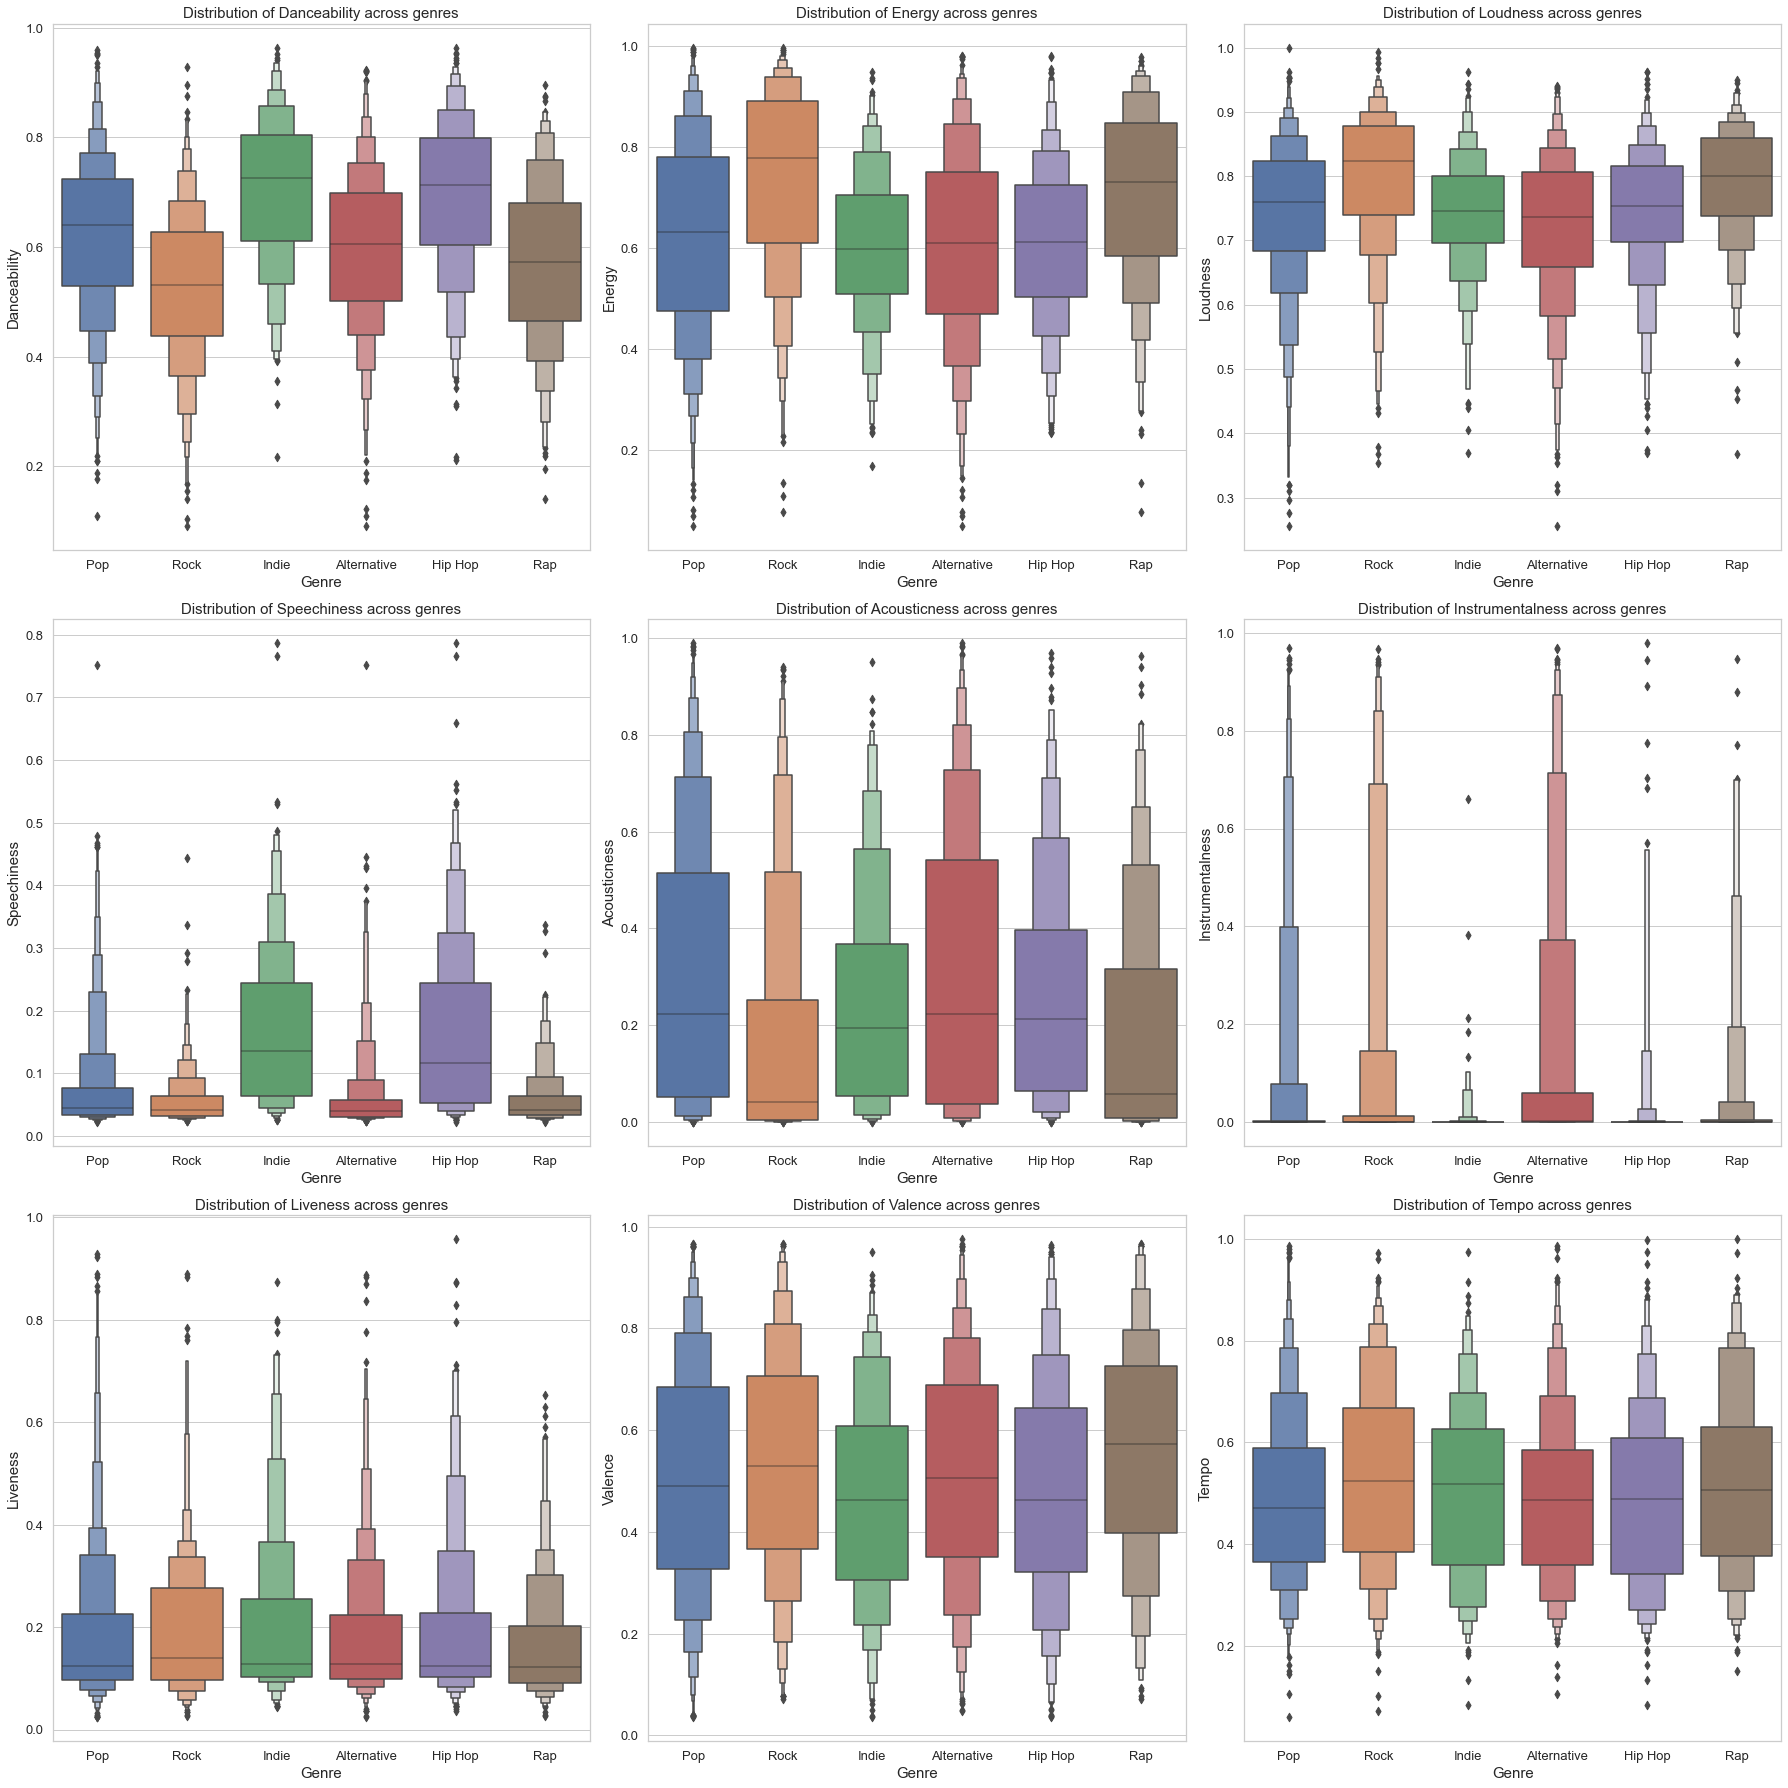

In [20]:
tmp_df = pd.DataFrame()
for genre in ['pop','rock','hip_hop','indie','rap','alternative']:
    mask = df_weighted[genre] == 1
    int_df = df_weighted[mask].copy()
    int_df['genre'] = genre
    tmp_df = pd.concat([tmp_df,int_df])

plt.figure(figsize=(25,25))
for idx, feat in enumerate(feature_cols, start=1):
    plt.subplot(3,3,idx)
    sns.boxenplot(y=feat, x='genre', data=tmp_df)
    plt.title(f'Distribution of {feat.capitalize()} across genres', fontsize=15)
    plt.ylabel(feat.capitalize(), fontsize=15)
    plt.xlabel('Genre', fontsize=15)
    plt.xticks(ticks=range(6),labels=['Pop','Rock','Indie','Alternative','Hip Hop','Rap'], fontsize=13)
    plt.yticks(fontsize=13)

plt.tight_layout()

save_path = f'{FIG_SAVE_PATH}/track_feature_dist_mapped_genres.png'
if not path.exists(save_path):
    plt.savefig(save_path, bbox_inches='tight')

plt.show()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.441   0.665    1  0.809852     1       0.0427        0.0147   
1            0.379   0.427    2  0.661284     1       0.0480        0.6460   
3            0.286   0.393    0  0.746681     1       0.0299        0.3550   
5            0.431   0.687    0  0.774351     1       0.0493        0.5860   
6            0.672   0.223    3  0.361202     1       0.0344        0.6540   
...            ...     ...  ...       ...   ...          ...           ...   
3280         0.606   0.275   10  0.634435     1       0.0288        0.3900   
3285         0.617   0.510    0  0.691826     0       0.0289        0.6400   
3310         0.650   0.829   11  0.841662     0       0.0511        0.1940   
3319         0.796   0.606    9  0.676686     0       0.0560        0.1750   
3321         0.705   0.831    1  0.859002     0       0.0311        0.1930   

      instrumentalness  liveness  valence     tempo                      id  \
0             0.000000     0.101    0.287  0.701600  2zzd1o3NLUPt4nAEMdBDdA   
1             0.000000     0.109    0.459  0.879928  5IcTrw1JntFyNFpWLJgQrH   
3             0.000000     0.123    0.202  0.183102  6bSKNdog2KlfDPRYyHZtBO   
5             0.000000     0.300    0.351  0.618467  2aEkwMP0T1qaAo1qLoI9gl   
6             0.000000     0.083    0.395  0.495084  6aKlaawInyn7voLfNm2XR3   
...                ...       ...      ...       ...                     ...   
3280          0.000000     0.135    0.190  0.258506  2UvMgTm9y3lStOyQE2yxKA   
3285          0.000266     0.116    0.705  0.471219  07FZOq9SUuITVCNE0oTm1k   
3310          0.000000     0.350    0.634  0.524789  391NzELM5jOnG6bte67GpB   
3319          0.000004     0.076    0.495  0.519322  2xcinH0acfCEZhflJuokip   
3321          0.000068     0.203    0.780  0.335112  4zfsk7inEPq0PawGyU6oHi   

      duration_ms  time_signature  playlist_track_id                name  \
0          319653               4               1853                  昨天   
1          278160               4               1841                  苦瓜   
3          216000               4               1848                閉目入神   
5          271354               4               1870                念念不忘   
6          230083               4               1814                  劇透   
...           ...             ...                ...                 ...   
3280       154074               4                531        Cotton Candy   
3285       231795               4                528      Close The Door   
3310       276930               4                447               春は溶けて   
3319       183084               4                423  Angles (feat. JME)   
3321       197450               4                454                  邦画   

      popularity         artist               artist_id  \
0             39            Mr.  5yocZHV4puj9QHb4xAXAtL   
1             47     Eason Chan  2QcZxAgcs2I1q7CtCkl6MI   
3             38   Ronald Cheng  66FF9LF0uO3W1zxEN0m8uN   
5             42       Juno Mak  6YlGm6QDrC3TOknYcHjt62   
6              0       Kwan Gor  5vJp6mhsvKyUPZI1bU0c07   
...          ...            ...                     ...   
3280          54  Weston Estate  18CPEToK1OfjJ5B5vDBDKa   
3285          51  Weston Estate  18CPEToK1OfjJ5B5vDBDKa   
3310          50  indigo la End  26ZBeXl5Gqr3TAv2itmyCU   
3319          51      Miraa May  2fOvE1l01YyORhYzwoaLCM   
3321          49  indigo la End  26ZBeXl5Gqr3TAv2itmyCU   

               playlist_name       playlist_date_added  lang_jap  lang_kor  \
0                  Cantonese 2019-05-12 02:55:19+00:00         0         0   
1                  Cantonese 2019-05-12 02:55:19+00:00         0         0   
3                  Cantonese 2019-05-12 02:55:19+00:00         0         0   
5                  Cantonese 2019-05-12 02:55:19+00:00         0         0   
6                  Cantonese 2016-04-17 12:35:46+00:00         0         0   
...                      ...  

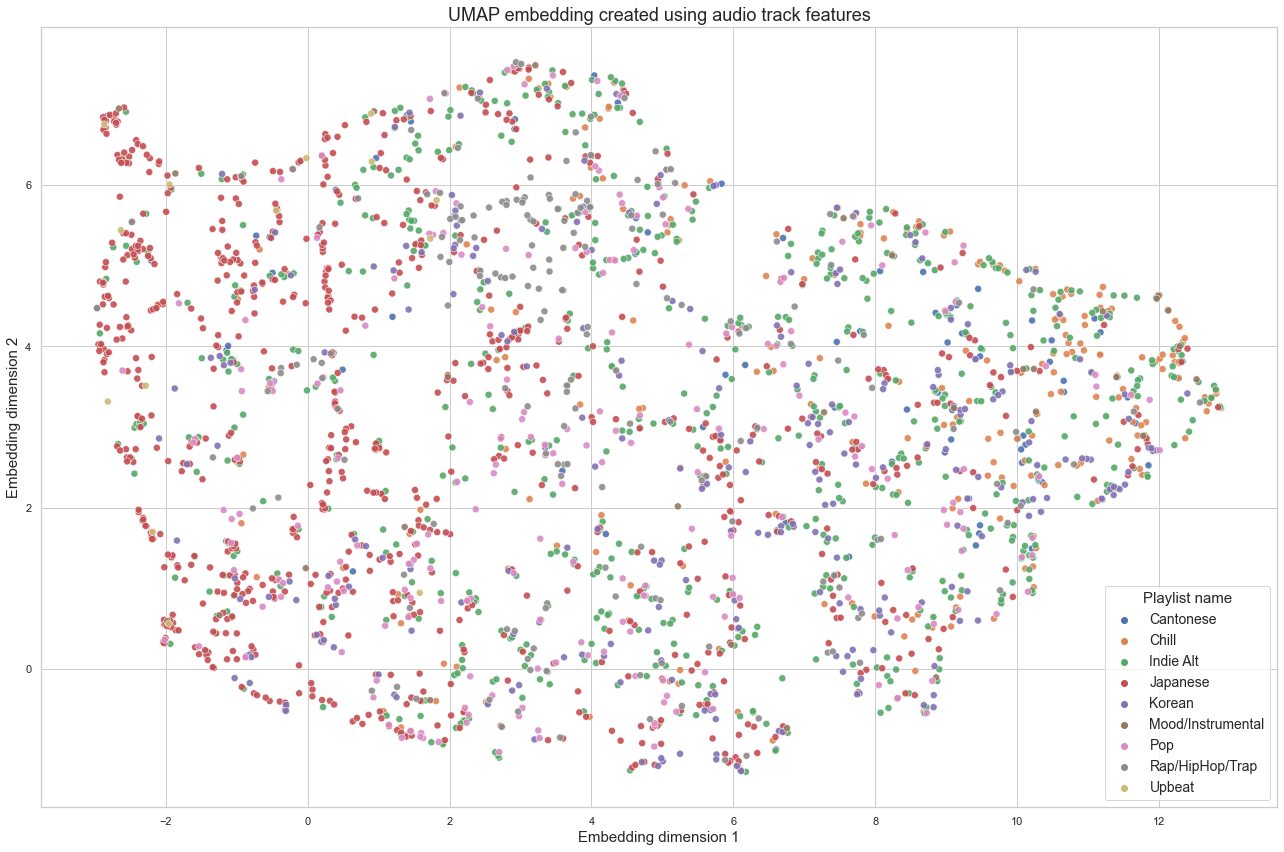

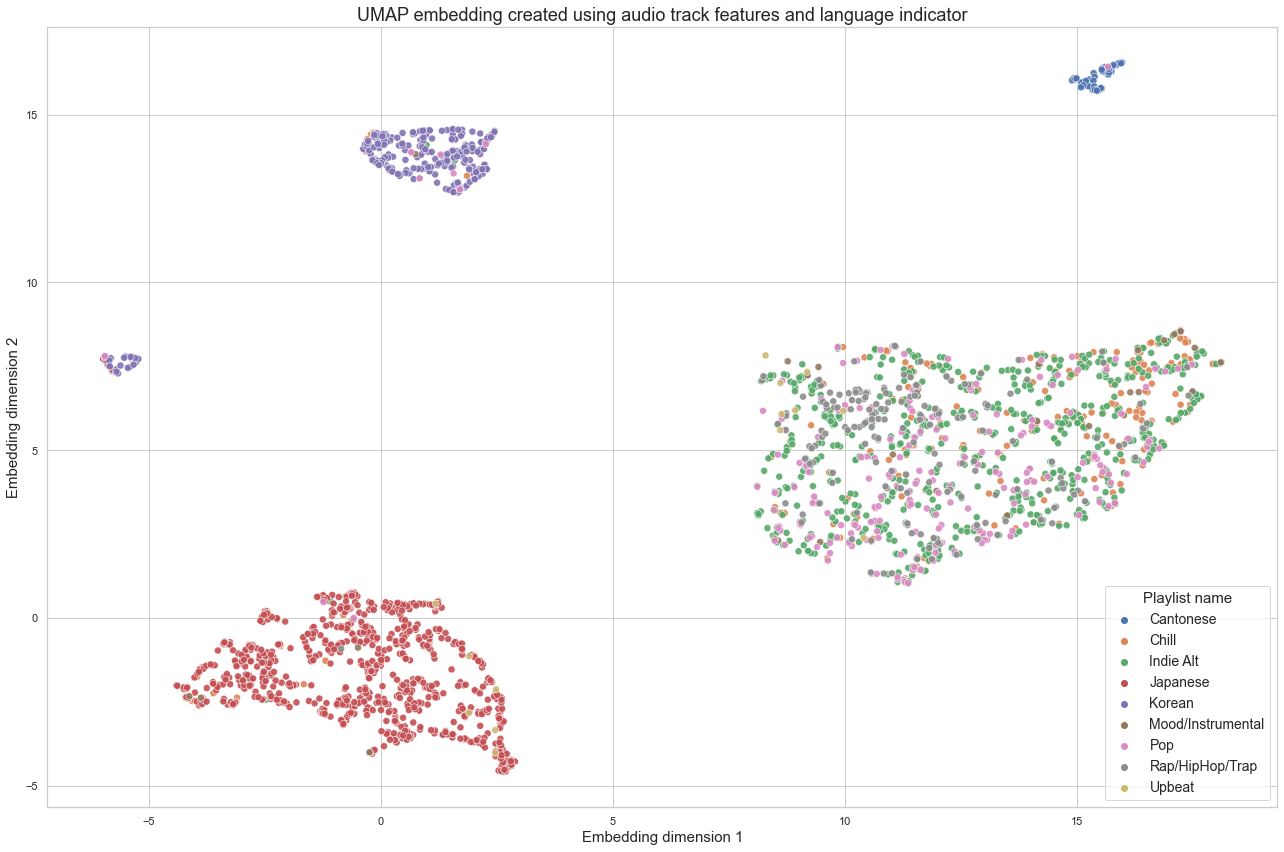

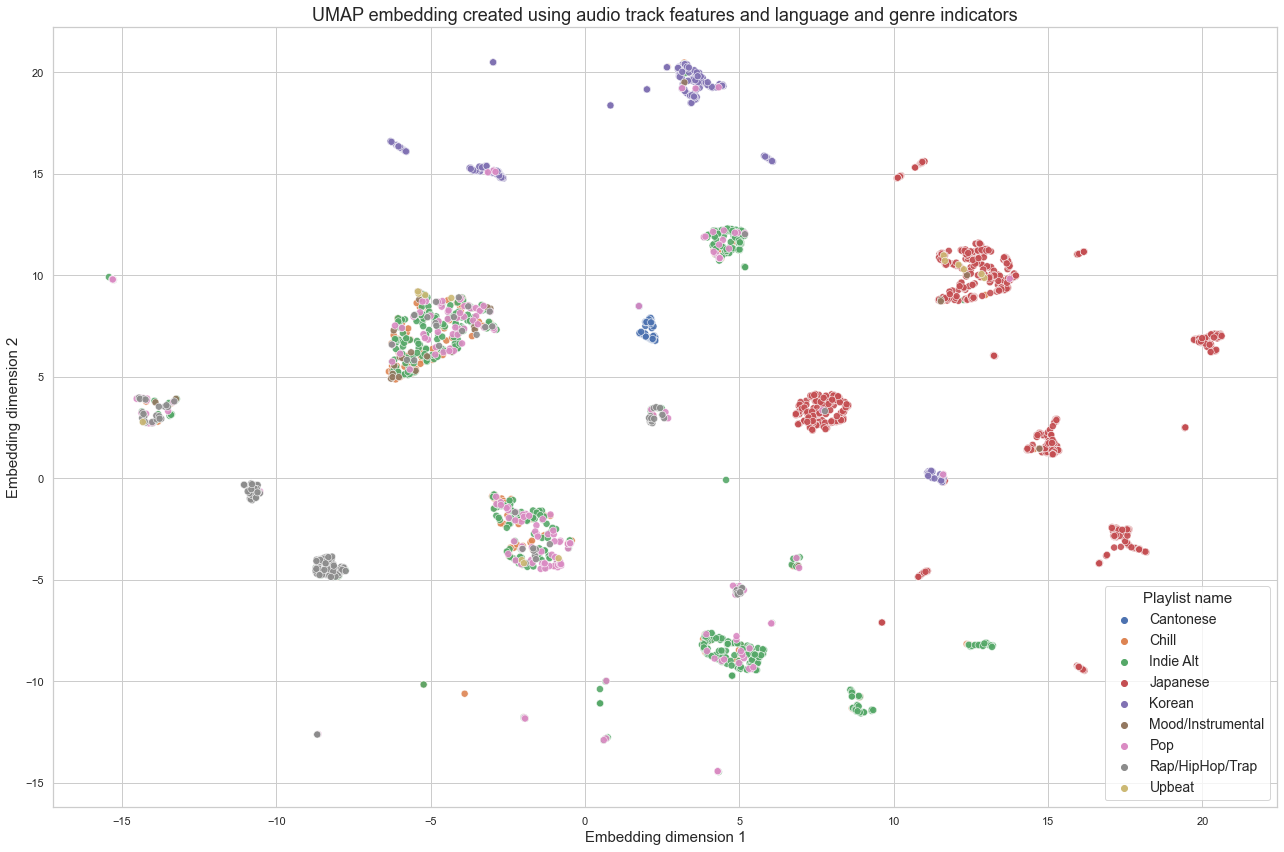

In [30]:
col_lists = [
    [
        'danceability',
        'energy',
        'loudness',
        'acousticness',
        'valence',
        'tempo'
    ],
    [
        'lang_eng',
        'lang_kor',
        'lang_jap',
        'lang_can'
    ],
    [
        'pop', 
        'rock', 
        'hip_hop', 
        'indie', 
        'rap',
        'alternative'
    ],
]
title_map = {
    0: 'UMAP embedding created using audio track features',
    1: 'UMAP embedding created using audio track features and language indicator',
    2: 'UMAP embedding created using audio track features and language and genre indicators',
}

for idx, lst in enumerate(col_lists):
    cols = [item for lst in col_lists[:idx+1] for item in lst]
    
    # DR using UMAP for 2d vis of data
    reducer = umap.UMAP(n_neighbors=6, random_state=42)
    embedding = reducer.fit_transform(df_weighted[cols])

    embedding_df = pd.DataFrame(embedding, columns=['dim_1', 'dim_2']).join(df_weighted[['playlist_name']])

    fig, ax = plt.subplots(figsize=(18,12))

    mask = embedding_df['playlist_name'].isin(['Korean', 'Japanese', 'Cantonese', 'Indie Alt', 'Pop', 'Rap/HipHop/Trap', 'Chill', 'Mood/Instrumental', 'Upbeat'])
    
    sns.scatterplot(
        x=embedding_df[mask]['dim_1'],
        y=embedding_df[mask]['dim_2'],
        s=50,
        alpha=0.9,
        ax=ax,
        hue=embedding_df[mask]['playlist_name']
    )

    plt.xlabel('Embedding dimension 1', fontsize=15)
    plt.ylabel('Embedding dimension 2', fontsize=15)
    plt.title(f'{title_map[idx]}', fontsize=18)
    plt.legend(title='Playlist name', title_fontsize=15, fontsize=14, loc='lower right')
    plt.tight_layout()
    plt.show()

In [6]:
# DR using UMAP for 2d vis of data
reducer = umap.UMAP(n_neighbors=6, random_state=234)
embedding = reducer.fit_transform(df_weighted[nn_feat_cols])

embedding_df = pd.DataFrame(embedding, columns=['dim_1', 'dim_2']).join(df_weighted[['playlist_name','lang_jap','lang_kor','lang_can','lang_eng','pop','rock','hip_hop','indie','rap','rnb','alternative']])

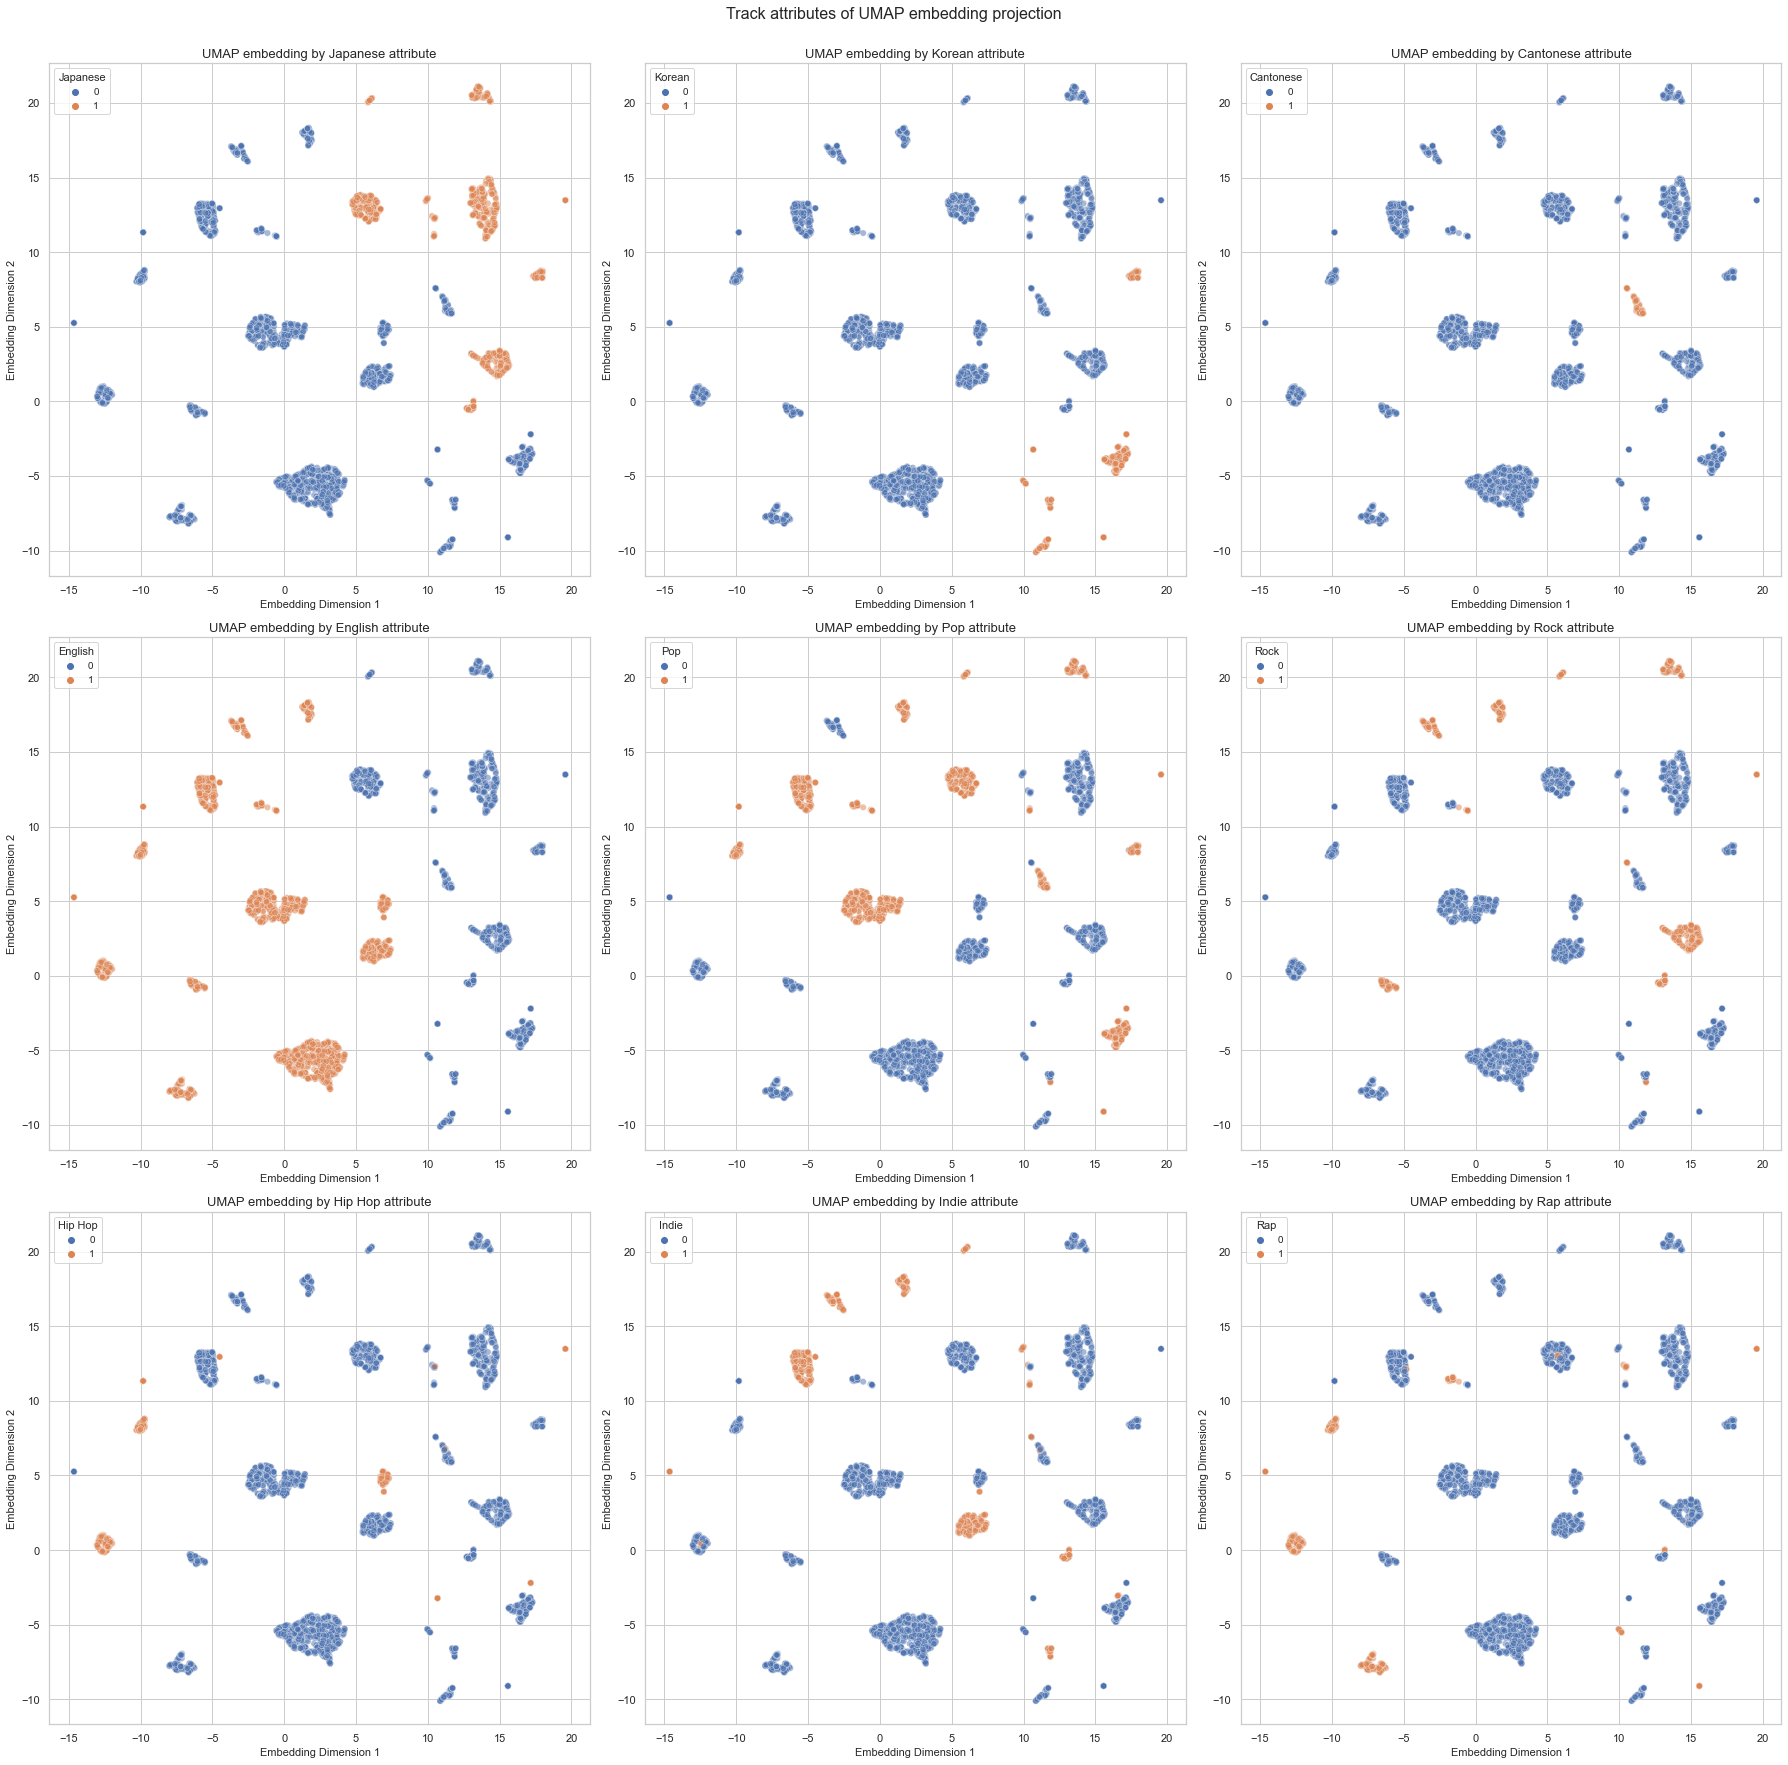

In [7]:
title_map = {
    'lang_jap': 'Japanese',
    'lang_kor': 'Korean',
    'lang_can': 'Cantonese',
    'lang_eng': 'English',
    'pop': 'Pop',
    'rock': 'Rock', 
    'hip_hop': 'Hip Hop',
    'indie': 'Indie',
    'rap': 'Rap',
    'alternative': 'Alternative',
}

plt.figure(figsize=(35,25))

for idx, genre in enumerate(title_map, 1):
    plt.subplot(3,4,idx)
    sns.scatterplot(
        x=embedding_df['dim_1'],
        y=embedding_df['dim_2'],
        s=40,
        alpha=0.5,
        hue=embedding_df[genre]
    )
    plt.xlabel('Embedding Dimension 1', fontsize=13)
    plt.ylabel('Embedding Dimension 2', fontsize=13)
    plt.title(f'UMAP embedding by {title_map[genre]} attribute', fontsize=15)
    plt.legend(title=title_map[genre], title_fontsize=13, fontsize=12, loc='upper left')

plt.suptitle('Track attributes of UMAP embedding projection', fontsize=19)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [213]:

# DR using UMAP for 3d vis of data
reducer = umap.UMAP(n_neighbors=30, n_components=3)
embedding = reducer.fit_transform(df_weighted[nn_feat_cols])

fig = px.scatter_3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    width=800,
    height=800
)

fig.update_traces(
    marker=dict(size=2),
    selector=dict(mode='markers')
)

fig.show()